In [1]:
import phate
import scprep
import seaborn as sns
import os
import json
from PIL import Image, ImageDraw
import re
import numpy as np
import cv2
import imageio
import matplotlib.pyplot as plt
import tifffile as tiff
from tqdm import tqdm
from skimage.exposure import equalize_adapthist
from scipy.stats import stats
import matplotlib.animation as animation
import pandas as pd
import csv
import shutil
from skimage.morphology import dilation, erosion
import numpy as np
import matplotlib.pyplot as plt
import imageio
from skimage import measure
from skimage.measure import regionprops, label
from scipy.spatial import distance
import time
import datetime
from mpl_toolkits.mplot3d import Axes3D  # 3D Plotting
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import mean_squared_error, r2_score

import seaborn as sns
from scipy.ndimage import center_of_mass
from glob import glob
import random
import imageio.v2 as imageio
from tifffile import imread


# Centroid calculation by Mean

In [2]:
def analyze_cells_by_mask_labels_with_velocity_corrected(mask_directory, output_directory, size_threshold=1000):
    """Final version: Extract shape features and centroid velocities per cell per frame using true mask label values (not region.label),
    and remove repeated (Cell_ID, Frame) by keeping the row with the largest area."""

    def average_centroid(region):
        centroid = region.centroid  # (y, x) format
        cx, cy = centroid[1] * 0.68, centroid[0] * 0.68  # Convert to (x, y) and apply scaling
        return cx, cy

    def calculate_shape_factors(region):
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        convex_mask = region.convex_image.astype(np.uint8) * 255
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        cx, cy = average_centroid(region)

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}.")

    all_results = []

    for mask_path in mask_files:
        frame_str = os.path.splitext(os.path.basename(mask_path))[0]
        frame_match = re.search(r'\d+', frame_str)
        frame = int(frame_match.group()) if frame_match else None
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        if mask is None:
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]

        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            coords = region.coords
            actual_labels = np.unique(mask[coords[:, 0], coords[:, 1]])
            actual_labels = [val for val in actual_labels if val != 0]
            if not actual_labels:
                continue
            cell_id = actual_labels[0]
            all_results.append([cell_id, frame] + shape_factors)

    df = pd.DataFrame(all_results, columns=[
        "Cell_ID", "Frame", "Area", "Perimeter", "Solidity", "Extent",
        "Circularity", "Convexity", "Elongation", "Compactness", "Centroid_X", "Centroid_Y"
    ])

    # Sort and remove duplicates by keeping the row with largest area
    df.sort_values(by=["Cell_ID", "Frame", "Area"], ascending=[True, True, False], inplace=True)
    df = df.drop_duplicates(subset=["Cell_ID", "Frame"], keep="first")

    # Compute distances and frame differences
    df["X_Centroid_Distance"] = df.groupby("Cell_ID")["Centroid_X"].diff().fillna(0)
    df["Y_Centroid_Distance"] = df.groupby("Cell_ID")["Centroid_Y"].diff().fillna(0)
    df["Frame_Diff"] = df.groupby("Cell_ID")["Frame"].diff()

    # Velocity calculations
    df["X_Centroid_Velocity"] = df["X_Centroid_Distance"] / df["Frame_Diff"]
    df["Y_Centroid_Velocity"] = df["Y_Centroid_Distance"] / df["Frame_Diff"]

    # Handle Frame_Diff == 0 (unexpected duplicates) and NaNs (first frame)
    df.loc[df["Frame_Diff"] == 0, ["X_Centroid_Velocity", "Y_Centroid_Velocity"]] = 0
    df.fillna({"X_Centroid_Velocity": 0, "Y_Centroid_Velocity": 0}, inplace=True)

    # Replace infs and very small values with 0
    df.replace([np.inf, -np.inf], 0, inplace=True)
    df["X_Centroid_Velocity"] = df["X_Centroid_Velocity"].apply(lambda x: 0 if abs(x) < 1e-6 else x)
    df["Y_Centroid_Velocity"] = df["Y_Centroid_Velocity"].apply(lambda x: 0 if abs(x) < 1e-6 else x)

    # Drop helper
    df.drop(columns="Frame_Diff", inplace=True)

    # Save
    os.makedirs(output_directory, exist_ok=True)
    corrected_csv_path = os.path.join(output_directory, "Cells_Shape_Features_TrueLabels_With_Velocity.csv")
    df.to_csv(corrected_csv_path, index=False)

    return df, corrected_csv_path




print("✔ Final version ready: Removes duplicate frames, computes safe velocities, and uses median-based centroids.")

#######  Example usage
mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/Track_New"

output_directory = "/home/MinaHossain/EmbedTrack/Track_New_Result_Shape/Mean"

results_df, csv_path = analyze_cells_by_mask_labels_with_velocity_corrected(mask_directory, output_directory)

# Display the first few rows of the resulting DataFrame
print(results_df.head(10))
print(f"CSV saved at: {csv_path}")


✔ Final version ready: Removes duplicate frames, computes safe velocities, and uses median-based centroids.
     Cell_ID  Frame     Area    Perimeter  Solidity    Extent  Circularity  \
0          1      0  19791.0  1305.303607  0.745677  0.512826     0.145967   
115        1     11  26265.0  1853.511760  0.681464  0.470092     0.096072   
166        1     16  28838.0  2041.151370  0.693788  0.527560     0.086981   
195        1     19  15902.0   982.634560  0.799377  0.590275     0.206956   
205        1     20  16554.0  1007.362482  0.820805  0.651476     0.204994   
215        1     21  15973.0  1015.605122  0.806229  0.676449     0.194602   
225        1     22  15973.0  1015.605122  0.806229  0.676449     0.194602   
236        1     23  24990.0  1675.671140  0.778966  0.587281     0.111840   
246        1     24  24693.0  1644.014285  0.778100  0.560428     0.114808   
256        1     25  25793.0  1693.156421  0.802520  0.564225     0.113062   

     Convexity  Elongation  Compa

# Centroid calculation by Mean
# Moving Average of Shape Features
# Cell ID matching with Tracking Masks

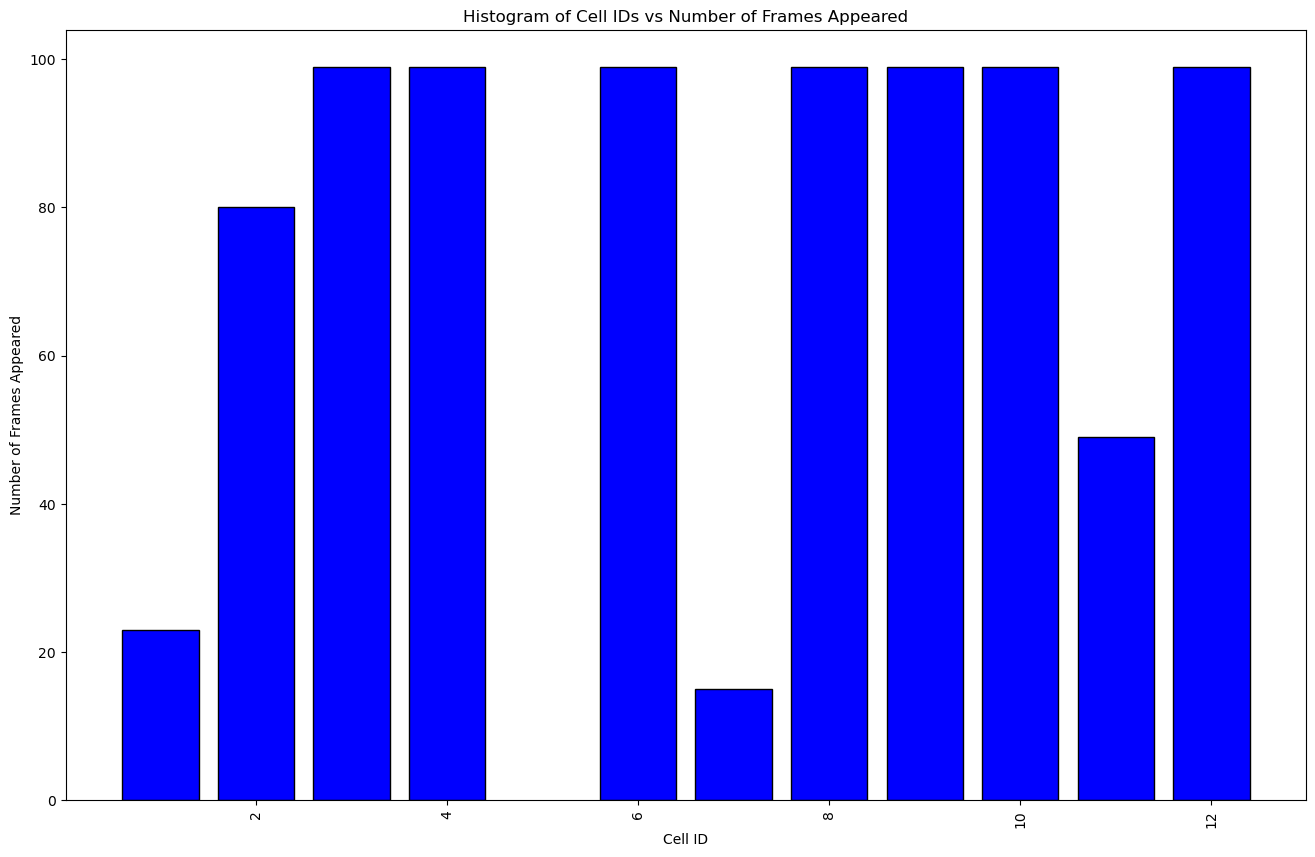

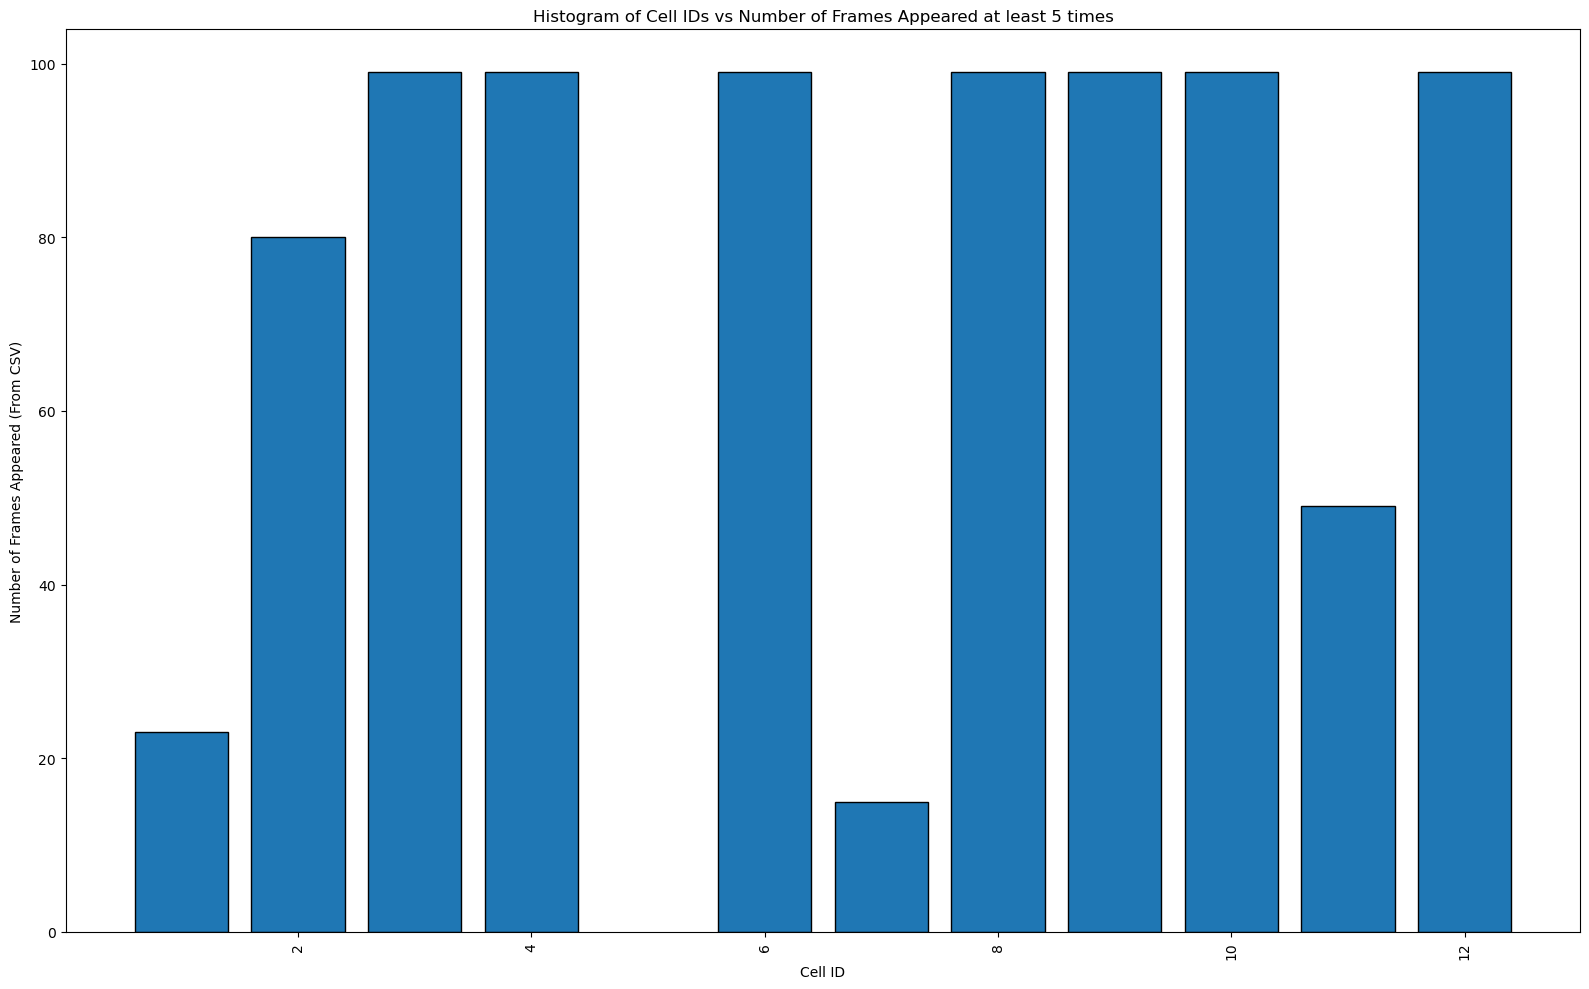

    Cell Number                                    Frames Appeared
0             1  [11, 16, 19, 20, 21, 22, 23, 24, 25, 26, 30, 3...
1             2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
2             3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
3             4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
4             6  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
5             7  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
6             8  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
7             9  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
8            10  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
9            11  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
10           12  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
Original results saved at: /home/MinaHossain/EmbedTrack/Track_New_Result_Shape/Mean/Cells_Centroid_Velocity_Original_TrueLabel_Mean_5.csv
Results with moving averages saved at: /home/MinaHossain/E

In [3]:
# # ====================
# # 👇 ADD THIS BLOCK 👇
# # ====================
# import pandas as pd
# import os
# import matplotlib.pyplot as plt
# import time

window_size = 5
start_time = time.time()

# Load CSV
output_directory = "/home/MinaHossain/EmbedTrack/Track_New_Result_Shape/Mean"
csv_path = "/home/MinaHossain/EmbedTrack/Track_New_Result_Shape/Mean/Cells_Shape_Features_TrueLabels_With_Velocity.csv"
df = pd.read_csv(csv_path)

# Rename for consistency
df.rename(columns={"Cell_ID": "Cell Number"}, inplace=True)

# Remove rows where velocity is zero
df = df[(df["X_Centroid_Velocity"] != 0) & (df["Y_Centroid_Velocity"] != 0)]

# Keep only cells with at least 5 frames
frame_counts = df.groupby("Cell Number")["Frame"].nunique()
valid_cells = frame_counts[frame_counts >= 5].index
df = df[df["Cell Number"].isin(valid_cells)].sort_values(by=["Cell Number", "Frame"])

# Frame list
frame_list = df.groupby("Cell Number")["Frame"].apply(list).reset_index()
frame_list.columns = ["Cell Number", "Frames Appeared"]

# Save outputs
os.makedirs(output_directory, exist_ok=True)

original_csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_Original_TrueLabel_Mean_{window_size}.csv")
df.to_csv(original_csv_path, index=False)

frame_list_path = os.path.join(output_directory, f"Cells_Frames_List_HP4_Sign_TrueLabel_Mean_{window_size}.csv")
frame_list.to_csv(frame_list_path, index=False)

# Moving averages
moving_average_variables = [
    "Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation",
    "Circularity", "Convexity", "Centroid_X", "Centroid_Y",
    "X_Centroid_Distance", "Y_Centroid_Distance", "X_Centroid_Velocity", "Y_Centroid_Velocity"
]

for var in moving_average_variables:
    df[f"{var}_MA"] = df.groupby("Cell Number")[var].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())

# Save MA CSV
ma_csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_TrueLabel_MA_Mean_{window_size}.csv")
df.to_csv(ma_csv_path, index=False)

# Plot
plt.figure(figsize=(16, 10))
plt.bar(frame_counts.index, frame_counts.values, color='blue', edgecolor='black')
plt.xlabel("Cell ID")
plt.ylabel("Number of Frames Appeared")
plt.title("Histogram of Cell IDs vs Number of Frames Appeared")
plt.xticks(rotation=90)
plt.savefig(os.path.join(output_directory, f"Cell_IDs_vs_Frames_Distribution_Cell_WTZV.png"))
plt.show()

# Bar plot from frame list
if os.path.exists(frame_list_path):
    frame_list_df = pd.read_csv(frame_list_path)
    frame_list_df["Frames Count"] = frame_list_df["Frames Appeared"].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)

    plt.figure(figsize=(16, 10))
    plt.bar(frame_list_df["Cell Number"], frame_list_df["Frames Count"], edgecolor='black')
    plt.xlabel("Cell ID")
    plt.ylabel("Number of Frames Appeared (From CSV)")
    plt.title(f"Histogram of Cell IDs vs Number of Frames Appeared at least {window_size} times")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, f"Cell_IDs_vs_Frames_0{window_size}.png"))
    plt.show()
else:
    print(f"Warning: {frame_list_path} not found. Skipping additional bar plot.")

# Summary
print(frame_list)
print(f"Original results saved at: {original_csv_path}")
print(f"Results with moving averages saved at: {ma_csv_path}")
print(f"Execution Time: {time.time() - start_time:.2f} seconds")


In [10]:


# def analyze_cells_by_mask_labels_with_velocity_corrected(mask_directory, output_directory, size_threshold=1000, window_size=5):
#     """Corrected & Enhanced: Extracts true-label shape features, centroid velocities, moving averages, and visualizations."""

#     start_time = time.time()

#     def median_centroid(region):
#         coords = region.coords
#         y_median = np.median(coords[:, 0])
#         x_median = np.median(coords[:, 1])
#         return x_median, y_median

#     def calculate_shape_factors(region):
#         area = region.area
#         perimeter = region.perimeter
#         convex_area = region.convex_area
#         bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

#         solidity = area / convex_area if convex_area > 0 else 0
#         extent = area / bounding_box_area if bounding_box_area > 0 else 0
#         circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

#         convex_mask = region.convex_image.astype(np.uint8) * 255
#         contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#         convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
#         convexity = convex_perimeter / perimeter if perimeter > 0 else 0

#         min_diameter = region.minor_axis_length
#         max_diameter = region.major_axis_length
#         elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
#         compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

#         cx, cy = median_centroid(region)
#         cx *= 0.68
#         cy *= 0.68

#         return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

#     if not os.path.exists(mask_directory):
#         raise FileNotFoundError(f"The directory {mask_directory} does not exist.")

#     mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
#     if not mask_files:
#         raise FileNotFoundError(f"No TIFF files found in {mask_directory}.")

#     all_results = []

#     for mask_path in mask_files:
#         frame_str = os.path.splitext(os.path.basename(mask_path))[0]
#         frame_match = re.search(r'\d+', frame_str)
#         frame = int(frame_match.group()) if frame_match else None
#         mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
#         if mask is None:
#             continue

#         labeled_mask = label(mask)
#         properties = regionprops(labeled_mask)

#         filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]

#         for region in filtered_regions:
#             shape_factors = calculate_shape_factors(region)
#             coords = region.coords
#             actual_labels = np.unique(mask[coords[:, 0], coords[:, 1]])
#             actual_labels = [val for val in actual_labels if val != 0]
#             if not actual_labels:
#                 continue
#             cell_id = actual_labels[0]
#             all_results.append([cell_id, frame] + shape_factors)

#     df = pd.DataFrame(all_results, columns=[
#         "Cell Number", "Frame", "Area", "Perimeter", "Solidity", "Extent",
#         "Circularity", "Convexity", "Elongation", "Compactness", "Centroid_X", "Centroid_Y"
#     ])

#     df.sort_values(by=["Cell Number", "Frame"], inplace=True)

#     # Calculate velocities
#     df["X_Centroid_Distance"] = df.groupby("Cell Number")["Centroid_X"].diff().fillna(0)
#     df["Y_Centroid_Distance"] = df.groupby("Cell Number")["Centroid_Y"].diff().fillna(0)
#     df["Frame_Diff"] = df.groupby("Cell Number")["Frame"].diff().fillna(1)
#     df["X_Centroid_Velocity"] = df["X_Centroid_Distance"] / df["Frame_Diff"]
#     df["Y_Centroid_Velocity"] = df["Y_Centroid_Distance"] / df["Frame_Diff"]
#     df.drop(columns="Frame_Diff", inplace=True)

#     # Remove velocity=0 rows
#     df = df[(df["X_Centroid_Velocity"] != 0) & (df["Y_Centroid_Velocity"] != 0)]

#     # Filter cells with at least 5 frames
#     frame_counts = df.groupby("Cell Number")["Frame"].nunique()
#     valid_cells = frame_counts[frame_counts >= 5].index
#     df = df[df["Cell Number"].isin(valid_cells)].sort_values(by=["Cell Number", "Frame"])

#     # Frame list generation
#     frame_list = df.groupby("Cell Number")["Frame"].apply(list).reset_index()
#     frame_list.columns = ["Cell Number", "Frames Appeared"]

#     os.makedirs(output_directory, exist_ok=True)

#     # Save original CSV
#     original_csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_Original_TrueLabel_Median_{window_size}.csv")
#     df.to_csv(original_csv_path, index=False)

#     # Save frame list
#     frame_list.to_csv(os.path.join(output_directory, f"Cells_Frames_List_HP4_Sign_TrueLabel_Median_{window_size}.csv"), index=False)

#     # Moving average computation
#     moving_average_variables = [
#         "Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation",
#         "Circularity", "Convexity", "Centroid_X", "Centroid_Y",
#         "X_Centroid_Distance", "Y_Centroid_Distance", "X_Centroid_Velocity", "Y_Centroid_Velocity"
#     ]

#     for var in moving_average_variables:
#         df[f"{var}_MA"] = df.groupby("Cell Number")[var].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())

#     # Save MA CSV
#     ma_csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_TrueLabel_MA_Median_{window_size}.csv")
#     df.to_csv(ma_csv_path, index=False)

#     # Histogram plot
#     plt.figure(figsize=(16, 10))
#     plt.bar(frame_counts.index, frame_counts.values, color='blue', edgecolor='black')
#     plt.xlabel("Cell ID")
#     plt.ylabel("Number of Frames Appeared")
#     plt.title("Histogram of Cell IDs vs Number of Frames Appeared")
#     plt.xticks(rotation=90)
#     plt.savefig(os.path.join(output_directory, f"Cell_IDs_vs_Frames_Distribution_Cell_WTZV.png"))
#     plt.show()

#     # Additional Bar Plot from frame_list CSV
#     frame_list_csv_path = os.path.join(output_directory, f"Cells_Frames_List_HP4_Sign_TrueLabel_Median_{window_size}.csv")
#     if os.path.exists(frame_list_csv_path):
#         frame_list_df = pd.read_csv(frame_list_csv_path)
#         frame_list_df["Frames Count"] = frame_list_df["Frames Appeared"].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)

#         plt.figure(figsize=(16, 10))
#         plt.bar(frame_list_df["Cell Number"], frame_list_df["Frames Count"], edgecolor='black')
#         plt.xlabel("Cell ID")
#         plt.ylabel("Number of Frames Appeared (From CSV)")
#         plt.title(f"Histogram of Cell IDs vs Number of Frames Appeared at least {window_size} times")
#         plt.xticks(rotation=90)
#         plt.tight_layout()
#         plt.savefig(os.path.join(output_directory, f"Cell_IDs_vs_Frames_0{window_size}.png"))
#         plt.show()
#     else:
#         print(f"Warning: {frame_list_csv_path} not found. Skipping additional bar plot.")

#     print(frame_list)
#     print(f"Original results saved at: {original_csv_path}")
#     print(f"Results with moving averages saved at: {ma_csv_path}")
#     print(f"Execution Time: {time.time() - start_time:.2f} seconds")

#     return df

# print("✔ Corrected version: Now using **median-based** centroids instead of mean. Moving Average of shapr Features")

# mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"
# output_directory = "/home/MinaHossain/EmbedTrack/Cell_Frame-Video/Shape_Measure-Median"

# results_df = analyze_cells_by_mask_labels_with_velocity_corrected(mask_directory, output_directory)
# print(results_df.head(15))





# Original VS Moving Average of Cells_Centroid_Velocity plot for a particular cell

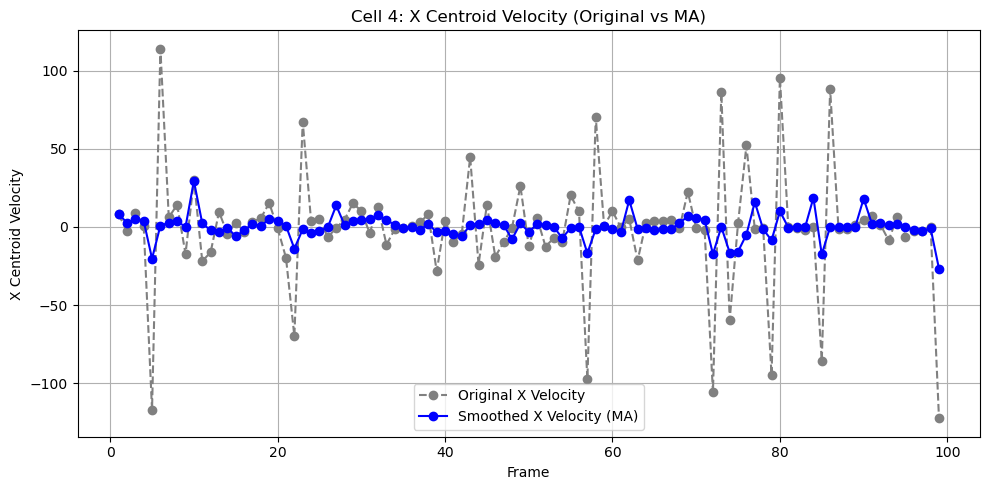

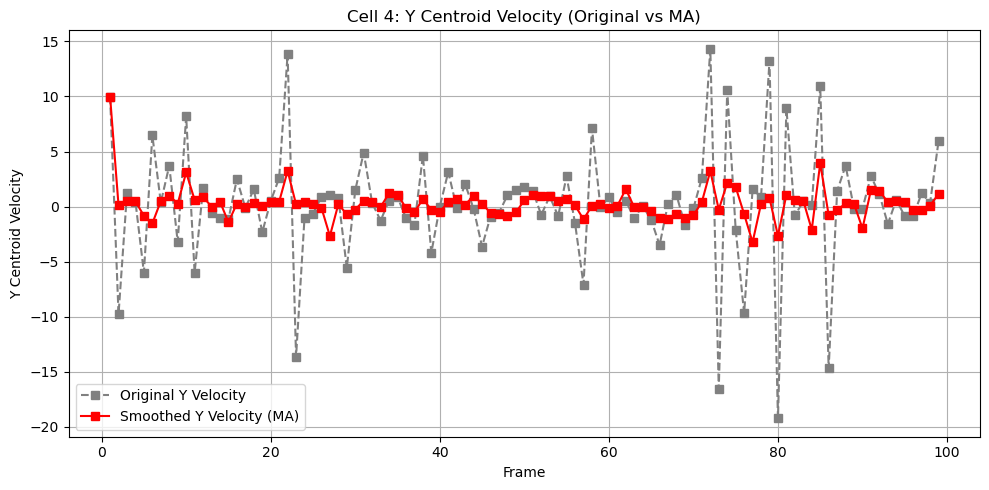

In [2]:
def plot_cell_velocity_comparison(input_directory,output_directory, cell_id, window_size):
    # File paths
    ma_csv_path = os.path.join(input_directory, f"Cells_Centroid_Velocity_TrueLabel_MA_Mean_{window_size}.csv")
    original_csv_path = os.path.join(input_directory, f"Cells_Centroid_Velocity_Original_TrueLabel_Mean_{window_size}.csv")

    # Check if files exist
    if not os.path.exists(ma_csv_path) or not os.path.exists(original_csv_path):
        print(f"Error: Required CSV files not found in {input_directory}")
        return

    # Load data
    df_ma = pd.read_csv(ma_csv_path)
    df_orig = pd.read_csv(original_csv_path)

    # Filter by Cell ID
    cell_ma = df_ma[df_ma["Cell Number"] == cell_id]
    cell_orig = df_orig[df_orig["Cell Number"] == cell_id]

    if cell_ma.empty or cell_orig.empty:
        print(f"No data found for Cell ID: {cell_id}")
        return

    # Sort frames just in case
    cell_ma = cell_ma.sort_values(by="Frame")
    cell_orig = cell_orig.sort_values(by="Frame")

    # Plot X Centroid Velocity
    plt.figure(figsize=(10, 5))
    plt.plot(cell_orig["Frame"], cell_orig["X_Centroid_Velocity"], marker='o', linestyle='--', color='gray', label='Original X Velocity')
    plt.plot(cell_ma["Frame"], cell_ma["X_Centroid_Velocity_MA"], marker='o', linestyle='-', color='blue', label='Smoothed X Velocity (MA)')
    plt.xlabel("Frame")
    plt.ylabel("X Centroid Velocity")
    plt.title(f"Cell {cell_id}: X Centroid Velocity (Original vs MA)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, f"Line_Plot_Frame VS X_Centroid_Velocity_MA{window_size}_{cell_id}.png"))
    plt.show()

    # Plot Y Centroid Velocity
    plt.figure(figsize=(10, 5))
    plt.plot(cell_orig["Frame"], cell_orig["Y_Centroid_Velocity"], marker='s', linestyle='--', color='gray', label='Original Y Velocity')
    plt.plot(cell_ma["Frame"], cell_ma["Y_Centroid_Velocity_MA"], marker='s', linestyle='-', color='red', label='Smoothed Y Velocity (MA)')
    plt.xlabel("Frame")
    plt.ylabel("Y Centroid Velocity")
    plt.title(f"Cell {cell_id}: Y Centroid Velocity (Original vs MA)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, f"Line_Plot_Frame VS Y_Centroid_Velocity_MA{window_size}_{cell_id}.png"))
    plt.show()


# Example Usage
# plot_cell_velocity("/home/MinaHossain/EmbedTrack/Moving_Average-Shape/", cell_id=2, window_size=5)
cell_id=4
window_size=5
input_directory="/home/MinaHossain/EmbedTrack/Track_New_Result_Shape/Mean"
output_directory="/home/MinaHossain/EmbedTrack/Track_New_Result_Shape/Mean"
plot_cell_velocity_comparison(input_directory,output_directory, cell_id, window_size)

# mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/Track_New"
# output_directory = "/home/MinaHossain/EmbedTrack/Cell_Frame-Video/Track_New_Output"




# Plot a Single Mask Frame with Labels

Labels in plot_labels function: [ 0  3  4  6  8  9 10 12]


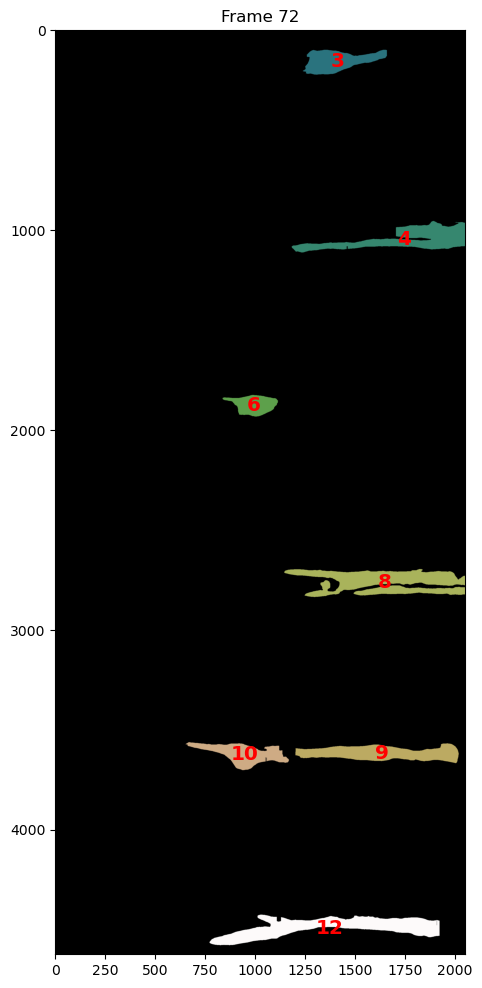

✅ Frame 72 plotted and saved to /home/MinaHossain/EmbedTrack/Cell_Frame-Video/Reg_Output/Frame_0072_labeled.png


In [11]:


# === Setup directories ===
# mask_dir = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"  # <-- Change if needed
# output_dir = "/home/MinaHossain/EmbedTrack/Cell_Frame-Video/Shape_Measure-Median"

mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/Track_New"
output_directory = "/home/MinaHossain/EmbedTrack/Cell_Frame-Video/Reg_Output"
os.makedirs(output_directory, exist_ok=True)

def analyze_mask_from_path(mask_path, frame_num):
    def plot_labels(original, ax, title=None,
                    txt_args={'color': 'red', 'ha': 'center', 'va': 'center',
                              'fontsize': 'x-large', 'fontweight': 'bold'},
                    cmap='gist_earth'):
        ax.imshow(original, cmap=cmap)
        labels = np.unique(original)
        print("Labels in plot_labels function:", labels)
        ax.set_title(title)
        for label in labels:
            if label != 0:
                inds = np.argwhere(original == label)
                loc = inds.mean(0)
                ax.text(loc[1], loc[0], str(label), **txt_args)

    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    if mask is None:
        raise ValueError(f"Could not read mask file: {mask_path}")

    fig, ax = plt.subplots(figsize=(12, 12))
    plot_labels(mask, ax, title=f"Frame {frame_num}")
    frame_output_path = os.path.join(output_directory, f"Frame_{frame_num:04d}_labeled.png")
    # plt.savefig(frame_output_path)
    # plt.close()
    plt.show()
    print(f"✅ Frame {frame_num} plotted and saved to {frame_output_path}")

# === Example: Plot a specific frame ===
frame_to_plot = 72  # ← Change this to the frame number you want
frame_filename = f"mask{frame_to_plot:04d}.tif"  # Example: '001.tif'
frame_path = os.path.join(mask_directory, frame_filename)

analyze_mask_from_path(frame_path, frame_to_plot)


# Centroid Plot of cells in mask/frame

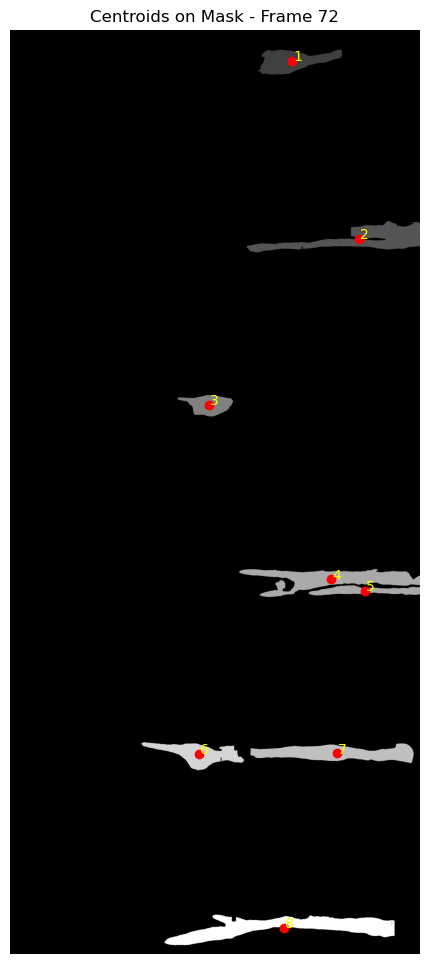

In [12]:
# === Configurable Parameters ===
# mask_dir = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"
# output_dir  = "/home/MinaHossain/EmbedTrack/Cell_Frame-Video/Shape_Measure-Median"


mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/Track_New"
output_directory = "/home/MinaHossain/EmbedTrack/Cell_Frame-Video/Reg_Output"

os.makedirs(output_directory, exist_ok=True)

# === Centroid Plot Function ===
def analyze_mask_from_path(mask_path, frame_num, size_threshold=1000, save=True):
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    if mask is None:
        raise ValueError(f"❌ Could not read mask file: {mask_path}")

    labeled_mask = label(mask)
    regions = regionprops(labeled_mask)

    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(mask, cmap='gray')
    ax.set_title(f"Centroids on Mask - Frame {frame_num}")
    ax.axis('off')

    for region in regions:
        if region.area >= size_threshold:
            y, x = region.centroid
            ax.plot(x, y, 'ro')  # red dot
            ax.text(x + 5, y, f'{region.label}', color='yellow', fontsize=10)

    if save:
        frame_output_path = os.path.join(output_directory, f"Mask_Centroid_{frame_num:04d}_labeled.png")
        # plt.savefig(frame_output_path)
        # plt.close()
        print(f"✅ Frame {frame_num} saved to: {frame_output_path}")
    else:
        plt.show()

# === Helper: Load by Frame Number ===
def visualize_centroids_for_frame(mask_directory, frame_number, size_threshold=1000, save=True):
    # Example filename pattern: mask0072.tif
    frame_filename = f"mask{frame_number:04d}.tif"
    mask_path = os.path.join(mask_directory, frame_filename)
    analyze_mask_from_path(mask_path, frame_number, size_threshold=size_threshold, save=save)

# === Example Usage ===
frame_to_plot = 72
visualize_centroids_for_frame(mask_directory, frame_to_plot, save=False)


# UPDATED 2-D PCA and Cluster Analysis, Box-Plot by Clusters

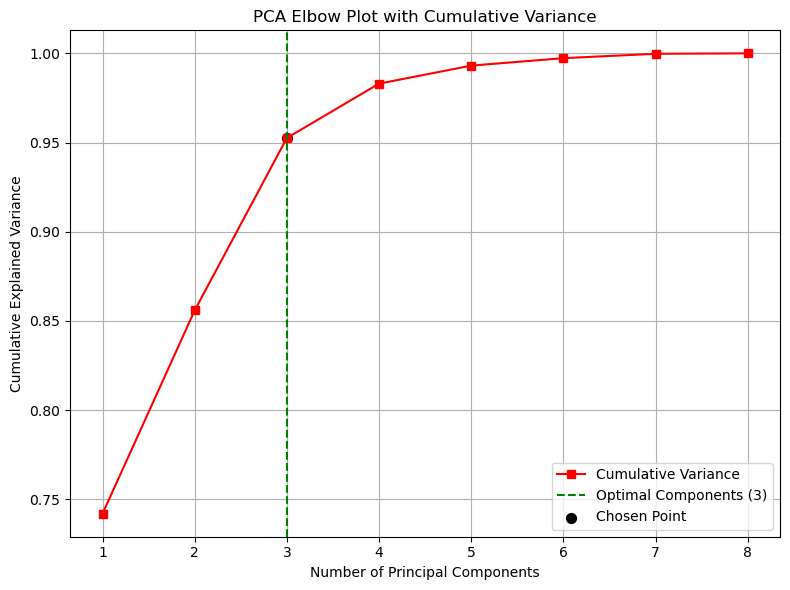

Optimal number of PCA components selected: 3


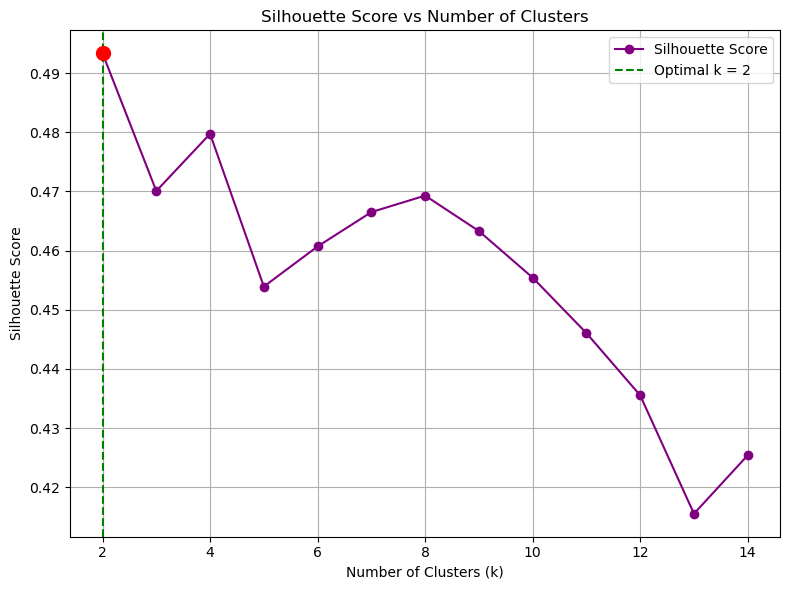

/tmp/ipykernel_1572639/3121749264.py:157: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1],


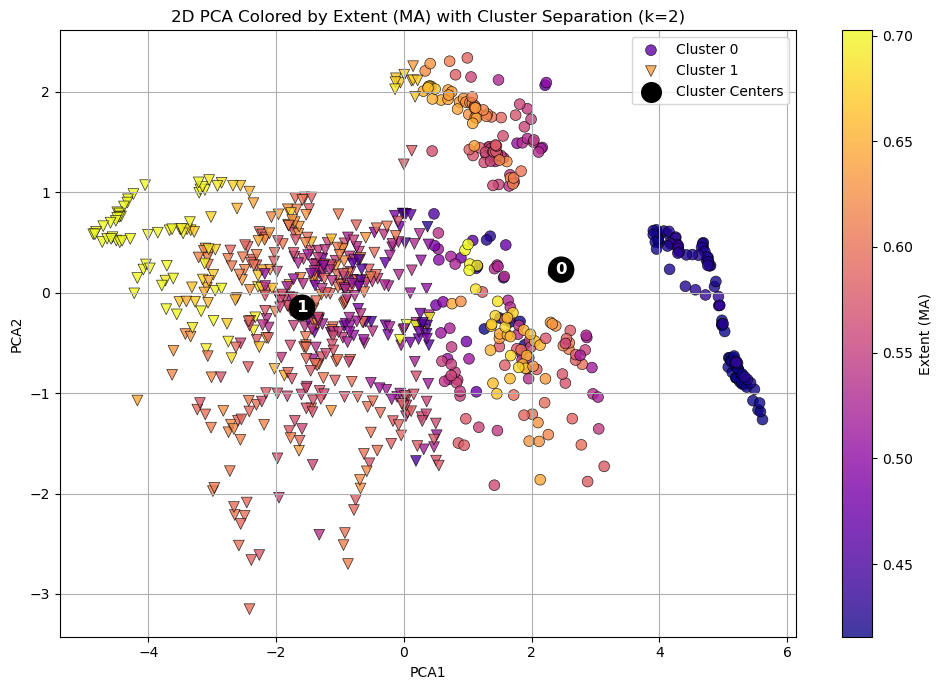

✅ PCA complete. Explained variance: [0.74190207 0.11398905 0.09666794 0.03045846 0.01010819]...
✅ Optimal K for clustering: 2
📁 Results saved: /home/MinaHossain/EmbedTrack/Track_New_Result_Shape/PCA_PHATE_Mean_PLOT/PCA_Cluster_Results_5.csv
📊 Cluster summary saved: /home/MinaHossain/EmbedTrack/Track_New_Result_Shape/PCA_PHATE_Mean_PLOT/PCA_Cluster_Summary_5.csv


/tmp/ipykernel_1572639/3121749264.py:203: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pca_df, x="Cluster", y="Extent_MA", palette="Set2")                                                # Change the name


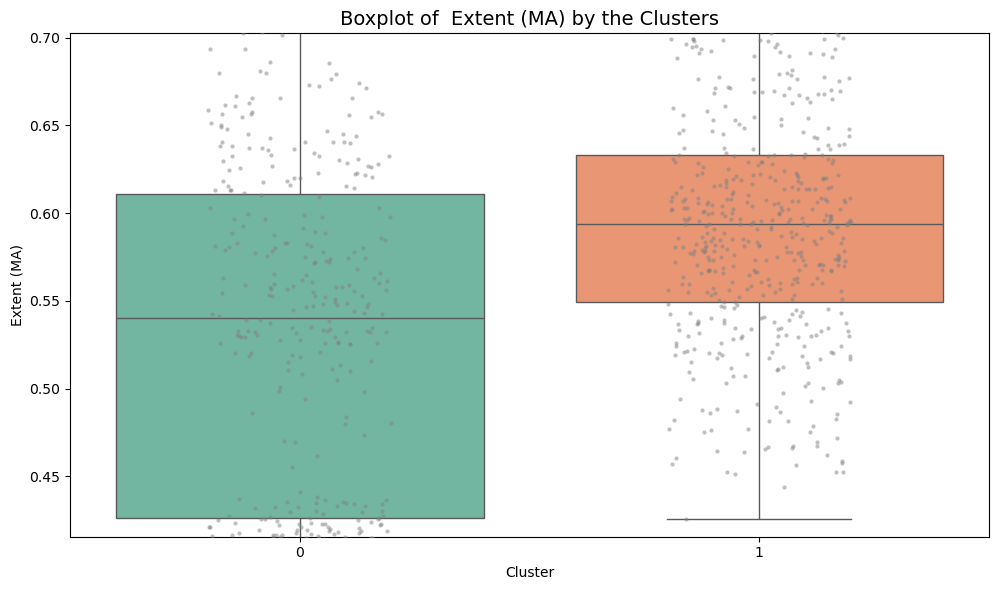

In [ ]:


def apply_pca_with_clustering(csv_path, output_directory, window_size):
    # Load data
    df = pd.read_csv(csv_path)
    selected_columns = ["Cell Number", "Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA", "Compactness_MA",
                        "Elongation_MA", "Circularity_MA", "Convexity_MA", 
                        "X_Centroid_Velocity_MA", "Y_Centroid_Velocity_MA"]
    
    mini_df = df[selected_columns].copy()

    # Standardize features (excluding Cell Number and velocity)
    features_to_scale = mini_df.drop(columns=["Cell Number", "X_Centroid_Velocity_MA", "Y_Centroid_Velocity_MA"])
    X_scaled = StandardScaler().fit_transform(features_to_scale)

    # --- PCA Variance Analysis and Elbow Plot ---
    pca_full = PCA()
    pca_full.fit(X_scaled)
    explained_variance = pca_full.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    optimal_components = np.argmax(cumulative_variance >= 0.95) + 1

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='s', linestyle='-', color='red', label="Cumulative Variance")
    plt.axvline(x=optimal_components, color='green', linestyle='--', label=f"Optimal Components ({optimal_components})")
    plt.scatter(optimal_components, cumulative_variance[optimal_components-1], color='black', s=50, label="Chosen Point")
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("PCA Elbow Plot with Cumulative Variance")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    # plt.savefig(os.path.join(output_directory, f"PCA_Elbow_Plot_{window_size}.png"))
    plt.show()

    print(f"Optimal number of PCA components selected: {optimal_components}")

    # --- Apply 2D PCA ---
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X_scaled)
    pca_df = pd.DataFrame(pca_result, columns=["PCA1", "PCA2"])
    pca_df["Cell Number"] = mini_df["Cell Number"]
    pca_df["Solidity_MA"] = mini_df["Solidity_MA"]                                                                # Change the Name

    # --- KMeans Clustering in 2D PCA Space ---
    silhouette_scores = []
    k_range = range(2,15)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto').fit(pca_df[["PCA1", "PCA2"]])
        score = silhouette_score(pca_df[["PCA1", "PCA2"]], kmeans.labels_)
        silhouette_scores.append(score)

    # Plot silhouette scores vs k with annotation
    optimal_k = k_range[np.argmax(silhouette_scores)]
    optimal_score = max(silhouette_scores)

    plt.figure(figsize=(8, 6))
    plt.plot(k_range, silhouette_scores, marker='o', linestyle='-', color='purple', label="Silhouette Score")
    plt.axvline(x=optimal_k, color='green', linestyle='--', label=f"Optimal k = {optimal_k}")
    plt.scatter(optimal_k, optimal_score, color='red', s=100, zorder=5)
    # plt.annotate(f"Best k = {optimal_k}\nScore = {optimal_score:.2f}",
    #              xy=(optimal_k, optimal_score),
    #              xytext=(optimal_k + 0.3, optimal_score - 0.05),
    #              arrowprops=dict(facecolor='black', arrowstyle="->"),
    #              fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray"))
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Score vs Number of Clusters")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    # plt.savefig(os.path.join(output_directory, f"Silhouette_Score_vs_K_{window_size}.png"))
    plt.show()

    # --- Final Clustering ---
    kmeans = KMeans(n_clusters=optimal_k, random_state=0, n_init='auto')
    pca_df["Cluster"] = kmeans.fit_predict(pca_df[["PCA1", "PCA2"]])
    cluster_centers = kmeans.cluster_centers_

    # --- Save PCA+Cluster Results ---
    output_csv = os.path.join(output_directory, f"PCA_Cluster_Results_{window_size}.csv")
    pca_df.to_csv(output_csv, index=False)

    # # --- Plot 2D PCA colored by X Centroid Velocity ---
    # vmin = np.percentile(pca_df["Perimeter_MA"], 5)                                                                                                 # Change the name
    # vmax = np.percentile(pca_df["Perimeter_MA"], 95)

    # plt.figure(figsize=(10, 7))
    # sc = plt.scatter(pca_df["PCA1"], pca_df["PCA2"], c=pca_df["Perimeter_MA"], cmap="plasma", alpha=0.8, vmin=vmin, vmax=vmax)            # Change the name.
    # plt.colorbar(sc, label="Perimeter (MA)")
    # plt.title("2D PCA Scatter Plot Colored by Perimeter (MA)")
    # plt.xlabel("PCA1")
    # plt.ylabel("PCA2")
    # plt.grid(True)
    # plt.tight_layout()
    # plt.savefig(os.path.join(output_directory, f"PCA_2D_Scatter_Perimeter_{window_size}.png"))
    # plt.show()

    # # --- Plot 2D PCA colored by Cluster with Cluster Centers --- cmap="tab10"
    # plt.figure(figsize=(10, 7))
    # plt.scatter(pca_df["PCA1"], pca_df["PCA2"], c=pca_df["Cluster"], cmap="plasma", alpha=0.8, label='Cells',vmin=vmin, vmax=vmax)

    # # Plot cluster centers
    # plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='black', s=200, marker='o', label='Cluster Centers')
    # for idx, (x, y) in enumerate(cluster_centers):
    #     plt.text(x, y, f"{idx}", fontsize=12, fontweight='bold', ha='center', va='center', color='white',
    #              bbox=dict(facecolor='black', boxstyle='circle,pad=0.2'))

    # plt.title(f"2D PCA Scatter Plot of  Clusters (k={optimal_k})")
    # plt.xlabel("PCA1")
    # plt.ylabel("PCA2")
    # plt.legend()
    # plt.grid(True)
    # plt.tight_layout()
    # plt.savefig(os.path.join(output_directory, f"PCA_2D_Clusters_Perimeter_{window_size}.png"))                                                # Chnage the name
    # plt.show()


 

    

   

    # Set limits for Perimeter_MA color scaling
    vmin = np.percentile(pca_df["Solidity_MA"], 5)                                                                           # Change the name
    vmax = np.percentile(pca_df["Solidity_MA"], 95)

    plt.figure(figsize=(10, 7))

    # Choose marker shapes per cluster if few clusters
    markers = ['o', 'v', '*', "^", "H", "D", ".", 's', '^', 'D',  'P','X', '<', '>']  # Up to 14 clusters
    num_clusters = pca_df["Cluster"].nunique()

    for cluster_id in sorted(pca_df["Cluster"].unique()):
        cluster_data = pca_df[pca_df["Cluster"] == cluster_id]
        
        plt.scatter(
            cluster_data["PCA1"],
            cluster_data["PCA2"],
            c=cluster_data["Solidity_MA"],                                                                                                      # Change the name
            cmap="plasma",
            alpha=0.8,
            vmin=vmin,
            vmax=vmax,
            edgecolor='black',
            linewidth=0.5,
            s=60,
            marker=markers[cluster_id % len(markers)],  # Cycle through markers
            label=f"Cluster {cluster_id}"
        )

    # Colorbar to represent Perimeter_MA
    cbar = plt.colorbar()
    cbar.set_label("Solidity (MA)")                                                                                                               # Change the name

    # Cluster Centers
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
                c='black', s=200, marker='o', label='Cluster Centers',vmin=vmin, vmax=vmax)
    for idx, (x, y) in enumerate(cluster_centers):
        plt.text(x, y, f"{idx}", fontsize=12, fontweight='bold', ha='center', va='center', color='white',
                bbox=dict(facecolor='black', boxstyle='circle,pad=0.3'))

    plt.title(f"2D PCA Colored by Solidity (MA) with Cluster Separation (k={optimal_k})")                                                             # change the name
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, f"pAC_Solidity_Color_ClusterSeparated_{window_size}.png"))                                             # change the name
    plt.show()









    # --- Cluster Summary Statistics ---
    cluster_summary = pca_df.groupby("Cluster").agg({
        "PCA1": ["mean", "std"],
        "PCA2": ["mean", "std"],
        "Solidity_MA": ["mean", "std"],                                                                                                        # Change the name
    }).reset_index()
    cluster_summary.columns = ["_".join(col).strip("_") for col in cluster_summary.columns.values]

    summary_path = os.path.join(output_directory, f"PCA_Cluster_Summary_{window_size}.csv")
    cluster_summary.to_csv(summary_path, index=False)

    print(f"✅ PCA complete. Explained variance: {explained_variance[:5]}...")
    print(f"✅ Optimal K for clustering: {optimal_k}")
    print(f"📁 Results saved: {output_csv}")
    print(f"📊 Cluster summary saved: {summary_path}")

    

    # --- Seaborn Boxplot: X Centroid Velocity by Cluster ---
    vmin = pca_df["Solidity_MA"].quantile(0.05)                                                                                    # Change the name
    vmax = pca_df["Solidity_MA"].quantile(0.95)

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=pca_df, x="Cluster", y="Solidity_MA", palette="Set2")                                                # Change the name
    sns.stripplot(data=pca_df, x="Cluster", y="Solidity_MA", color='gray', alpha=0.5, jitter=0.2, size=3)
    plt.title(" Boxplot of  Solidity (MA) by the Clusters ", fontsize=14)                                                                     # Change the name
    plt.xlabel("Cluster")
    plt.ylabel("Solidity (MA)")                                                                                            # Change the name 
    plt.tight_layout()
    plt.ylim(vmin, vmax)
    # plt.ylim(-40, 40)
    plt.savefig(os.path.join(output_directory, f"Boxplot_Solidity_MA_By_Cluster_{window_size}.png"))                # Change the name
    plt.show()


    # # --- Compute Cluster-Wise Feature Means (for Clustermap) ---
    # feature_df = mini_df.drop(columns=["Cell Number"]).copy()
    # feature_df["Cluster"] = pca_df["Cluster"].values
    # cluster_feature_means = feature_df.groupby("Cluster").mean()

    # # --- Seaborn Clustermap of Cluster-wise Feature Means ---
    # clustermap_data = cluster_feature_means.copy()

    # sns.clustermap(clustermap_data, cmap="vlag", annot=True, fmt=".2f", linewidths=0.5,
    #                figsize=(12, 8), col_cluster=True, row_cluster=True, cbar_kws={"label": "Feature Mean"})
    # plt.suptitle(f"Clustermap: Cluster-wise Feature Profiles (k={optimal_k})", fontsize=14)
    # plt.subplots_adjust(top=0.93)

    # clustermap_path = os.path.join(output_directory, f"Cluster_Feature_Clustermap_K{optimal_k}_{window_size}.png")
    # # plt.savefig(clustermap_path)
    # plt.show()

    # print(f"🧬 Cluster feature clustermap saved: {clustermap_path}")



    # # --- Heatmap of Feature Means per Cluster ---
    # feature_df = mini_df.drop(columns=["Cell Number"]).copy()
    # feature_df["Cluster"] = pca_df["Cluster"].values  # align clusters
    # cluster_feature_means = feature_df.groupby("Cluster").mean()

    # plt.figure(figsize=(12, 6))
    # sns.heatmap(cluster_feature_means, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, cbar_kws={"label": "Feature Mean"})
    # plt.title(f"Cluster-wise Mean of Morphological and Velocity Features (k={optimal_k})")
    # plt.tight_layout()
    # heatmap_path = os.path.join(output_directory, f"Cluster_Feature_Mean_Heatmap_K{optimal_k}_{window_size}.png")
    # # plt.savefig(heatmap_path)
    # plt.show()

    # print(f"🧠 Feature mean heatmap saved: {heatmap_path}")






# Run it
window_size = 5
output_directory = "/home/MinaHossain/EmbedTrack/Track_New_Result_Shape/PCA_PHATE_Mean_PLOT"

input_directory= "/home/MinaHossain/EmbedTrack/Track_New_Result_Shape/Mean"

csv_path = os.path.join(input_directory, f"Cells_Centroid_Velocity_TrueLabel_MA_Mean_{window_size}.csv")
apply_pca_with_clustering(csv_path, output_directory, window_size)


# mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/Track_New"
# output_directory = "/home/MinaHossain/EmbedTrack/Cell_Frame-Video/Track_New_Output"


# ["Cell Number", "Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA", "Compactness_MA","Elongation_MA", "Circularity_MA", "Convexity_MA", "X_Centroid_Velocity_MA", "Y_Centroid_Velocity_MA"]


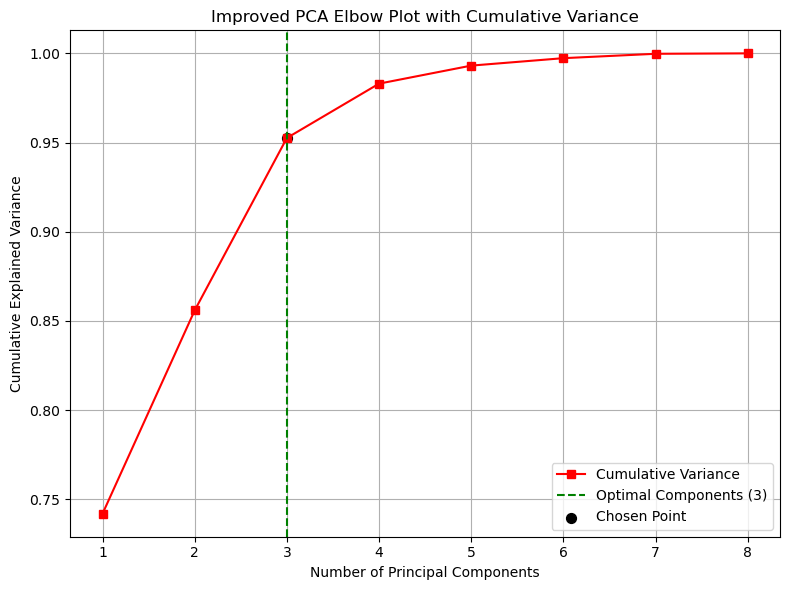

Optimal number of PCA components selected: 3


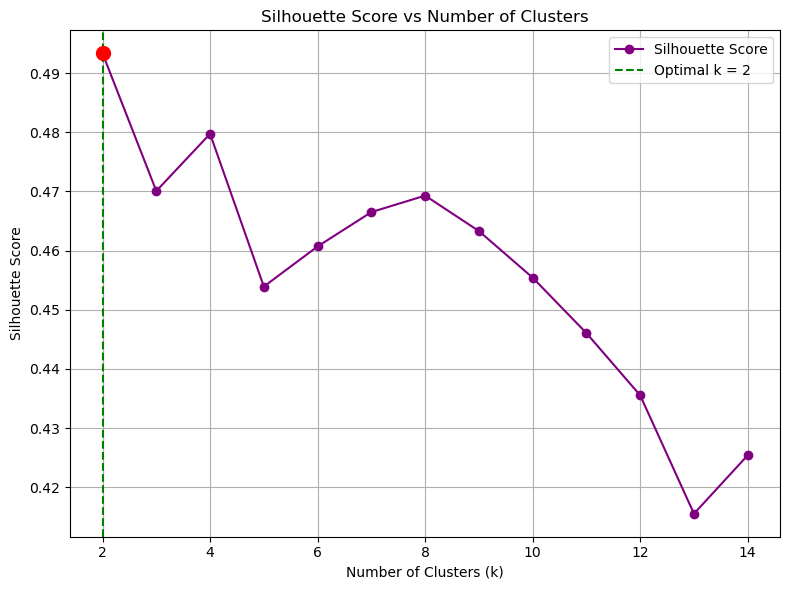

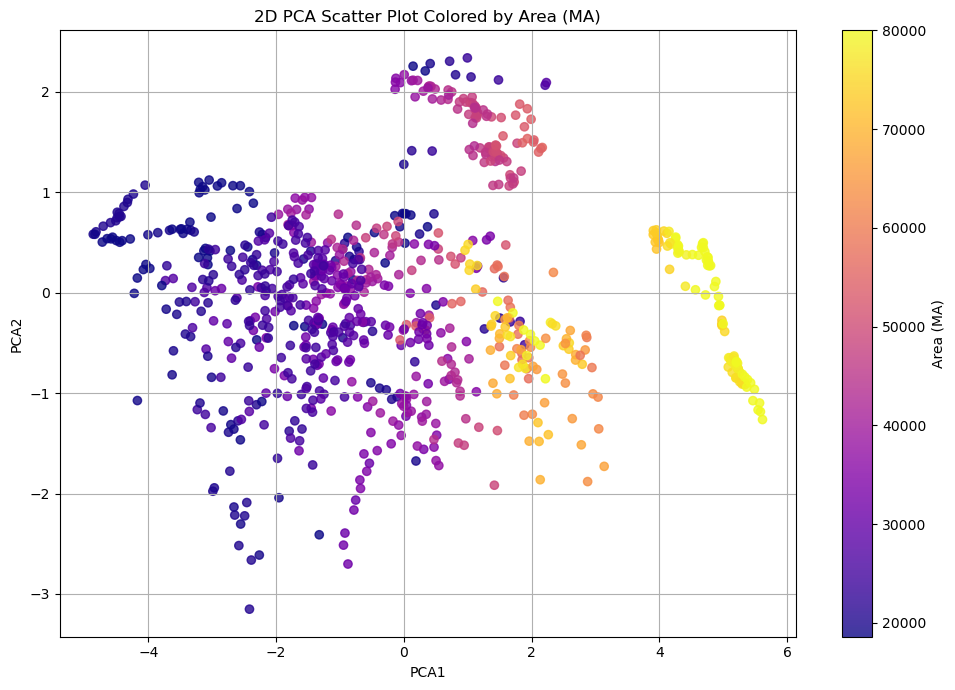

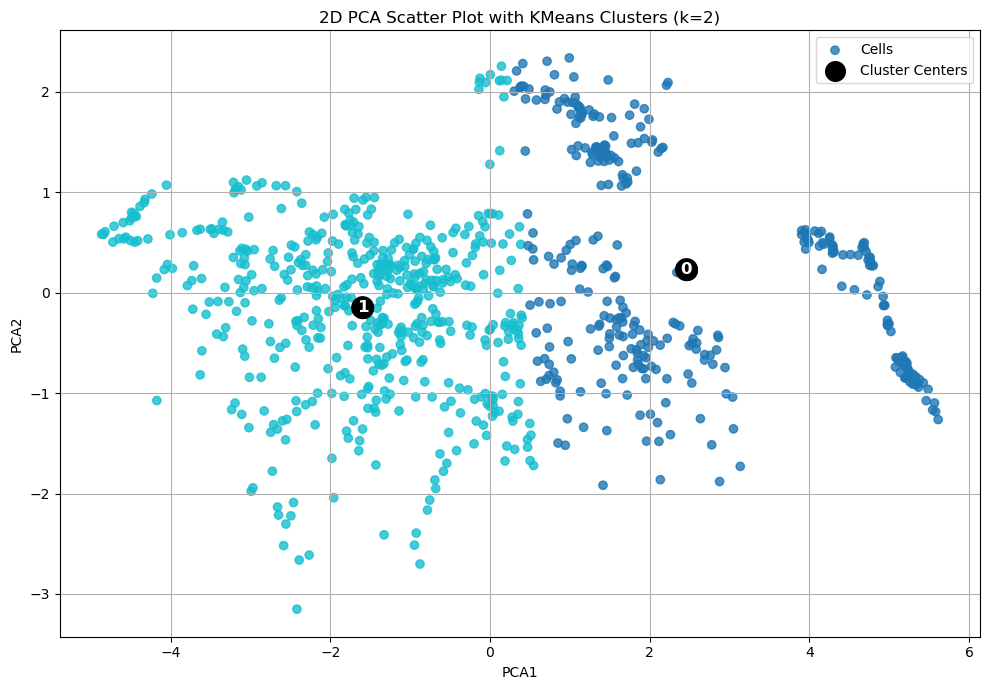

✅ PCA complete. Explained variance: [0.74190207 0.11398905 0.09666794 0.03045846 0.01010819]...
✅ Optimal K for clustering: 2
📁 Results saved: /home/MinaHossain/EmbedTrack/Track_New_Result_Shape/Mean/PCA_Cluster_Results_5.csv
📊 Cluster summary saved: /home/MinaHossain/EmbedTrack/Track_New_Result_Shape/Mean/PCA_Cluster_Summary_5.csv


/tmp/ipykernel_1998856/1036786489.py:172: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pca_df, x="Cluster", y="Area_MA", palette="Set2")


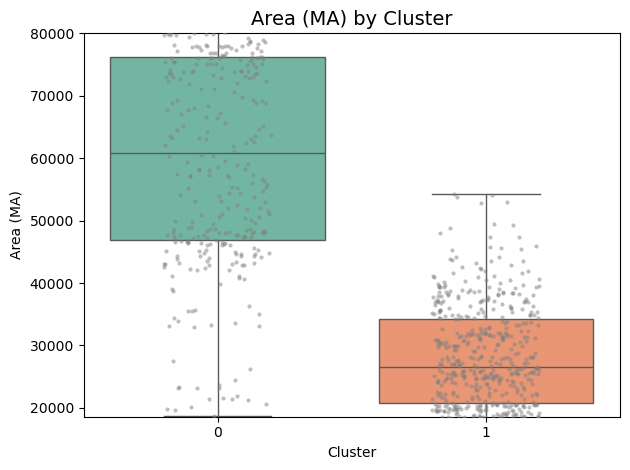

In [9]:


def apply_pca_with_clustering(csv_path, output_directory, window_size):
    # Load data
    df = pd.read_csv(csv_path)
    selected_columns = ["Cell Number", "Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA", "Compactness_MA",
                        "Elongation_MA", "Circularity_MA", "Convexity_MA", 
                        "X_Centroid_Velocity_MA", "Y_Centroid_Velocity_MA"]
    
    mini_df = df[selected_columns].copy()

    # Standardize features (excluding Cell Number and velocity)
    features_to_scale = mini_df.drop(columns=["Cell Number", "X_Centroid_Velocity_MA", "Y_Centroid_Velocity_MA"])
    X_scaled = StandardScaler().fit_transform(features_to_scale)

    # --- PCA Variance Analysis and Elbow Plot ---
    pca_full = PCA()
    pca_full.fit(X_scaled)
    explained_variance = pca_full.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    optimal_components = np.argmax(cumulative_variance >= 0.95) + 1

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='s', linestyle='-', color='red', label="Cumulative Variance")
    plt.axvline(x=optimal_components, color='green', linestyle='--', label=f"Optimal Components ({optimal_components})")
    plt.scatter(optimal_components, cumulative_variance[optimal_components-1], color='black', s=50, label="Chosen Point")
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("Improved PCA Elbow Plot with Cumulative Variance")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    # plt.savefig(os.path.join(output_directory, f"PCA_Elbow_Plot_{window_size}.png"))
    plt.show()

    print(f"Optimal number of PCA components selected: {optimal_components}")

    # --- Apply 2D PCA ---
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X_scaled)
    pca_df = pd.DataFrame(pca_result, columns=["PCA1", "PCA2"])
    pca_df["Cell Number"] = mini_df["Cell Number"]
    #pca_df["Y_Centroid_Velocity_MA"] = mini_df["Y_Centroid_Velocity_MA"]
    pca_df["Area_MA"] = mini_df["Area_MA"]

    # # --- KMeans Clustering in 2D PCA Space ---
    silhouette_scores = []
    k_range = range(2,15)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto').fit(pca_df[["PCA1", "PCA2"]])
        score = silhouette_score(pca_df[["PCA1", "PCA2"]], kmeans.labels_)
        silhouette_scores.append(score)

    # Plot silhouette scores vs k with annotation
    optimal_k = k_range[np.argmax(silhouette_scores)]
    optimal_score = max(silhouette_scores)

    plt.figure(figsize=(8, 6))
    plt.plot(k_range, silhouette_scores, marker='o', linestyle='-', color='purple', label="Silhouette Score")
    plt.axvline(x=optimal_k, color='green', linestyle='--', label=f"Optimal k = {optimal_k}")
    plt.scatter(optimal_k, optimal_score, color='red', s=100, zorder=5)
    # plt.annotate(f"Best k = {optimal_k}\nScore = {optimal_score:.2f}",
    #              xy=(optimal_k, optimal_score),
    #              xytext=(optimal_k + 0.3, optimal_score - 0.05),
    #              arrowprops=dict(facecolor='black', arrowstyle="->"),
    #              fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray"))
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Score vs Number of Clusters")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    # plt.savefig(os.path.join(output_directory, f"Silhouette_Score_vs_K_{window_size}.png"))
    plt.show()


    # optimal_k=5
    # --- Final Clustering ---
    kmeans = KMeans(n_clusters=optimal_k, random_state=0, n_init='auto')
    pca_df["Cluster"] = kmeans.fit_predict(pca_df[["PCA1", "PCA2"]])
    cluster_centers = kmeans.cluster_centers_

    # --- Save PCA+Cluster Results ---
    output_csv = os.path.join(output_directory, f"PCA_Cluster_Results_{window_size}.csv")
    pca_df.to_csv(output_csv, index=False)

    # --- Plot 2D PCA colored by X Centroid Velocity ---
    # vmin = np.percentile(pca_df["Y_Centroid_Velocity_MA"], 5)
    # vmax = np.percentile(pca_df["Y_Centroid_Velocity_MA"], 95)

    vmin = np.percentile(pca_df["Area_MA"], 5)
    vmax = np.percentile(pca_df["Area_MA"], 95)

    plt.figure(figsize=(10, 7))
    # sc = plt.scatter(pca_df["PCA1"], pca_df["PCA2"], c=pca_df["Y_Centroid_Velocity_MA"], cmap="plasma", alpha=0.8, vmin=vmin, vmax=vmax)
    # plt.colorbar(sc, label="Y Centroid Velocity (MA)")
    # plt.title("2D PCA Scatter Plot Colored by Y Centroid Velocity (MA)")

    sc = plt.scatter(pca_df["PCA1"], pca_df["PCA2"], c=pca_df["Area_MA"], cmap="plasma", alpha=0.8, vmin=vmin, vmax=vmax)
    plt.colorbar(sc, label="Area (MA)")
    plt.title("2D PCA Scatter Plot Colored by Area (MA)")


    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, f"PCA_2D_Area_{window_size}.png"))
    plt.show()

    # --- Plot 2D PCA colored by Cluster with Cluster Centers ---
    plt.figure(figsize=(10, 7))
    plt.scatter(pca_df["PCA1"], pca_df["PCA2"], c=pca_df["Cluster"], cmap="tab10", alpha=0.8, label='Cells')

    # Plot cluster centers
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='black', s=200, marker='o', label='Cluster Centers')
    for idx, (x, y) in enumerate(cluster_centers):
        plt.text(x, y, f"{idx}", fontsize=12, fontweight='bold', ha='center', va='center', color='white',
                 bbox=dict(facecolor='black', boxstyle='circle,pad=0.2'))

    plt.title(f"2D PCA Scatter Plot with KMeans Clusters (k={optimal_k})")
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, f"PCA_2D_Clusters_Area_{window_size}.png"))
    plt.show()

    # --- Cluster Summary Statistics ---
    # cluster_summary = pca_df.groupby("Cluster").agg({
    #     "PCA1": ["mean", "std"],
    #     "PCA2": ["mean", "std"],
    #     "Y_Centroid_Velocity_MA": ["mean", "std"],
    # }).reset_index()


    cluster_summary = pca_df.groupby("Cluster").agg({
        "PCA1": ["mean", "std"],
        "PCA2": ["mean", "std"],
        "Area_MA": ["mean", "std"],
    }).reset_index()


    cluster_summary.columns = ["_".join(col).strip("_") for col in cluster_summary.columns.values]

    summary_path = os.path.join(output_directory, f"PCA_Cluster_Summary_{window_size}.csv")
    cluster_summary.to_csv(summary_path, index=False)

    print(f"✅ PCA complete. Explained variance: {explained_variance[:5]}...")
    print(f"✅ Optimal K for clustering: {optimal_k}")
    print(f"📁 Results saved: {output_csv}")
    print(f"📊 Cluster summary saved: {summary_path}")

    

    # --- Seaborn Boxplot: X Centroid Velocity by Cluster ---
    # vmin = pca_df["Y_Centroid_Velocity_MA"].quantile(0.05)
    # vmax = pca_df["Y_Centroid_Velocity_MA"].quantile(0.95)


    vmin = pca_df["Area_MA"].quantile(0.05)
    vmax = pca_df["Area_MA"].quantile(0.95)

    # plt.figure(figsize=(10, 6))
    # sns.boxplot(data=pca_df, x="Cluster", y="Y_Centroid_Velocity_MA", palette="Set2")
    # sns.stripplot(data=pca_df, x="Cluster", y="Y_Centroid_Velocity_MA", color='gray', alpha=0.5, jitter=0.2, size=3)
    # plt.title("Y Centroid Velocity (MA) by Cluster", fontsize=14)
    # plt.xlabel("Cluster")
    # plt.ylabel("Y Centroid Velocity (MA)")


    sns.boxplot(data=pca_df, x="Cluster", y="Area_MA", palette="Set2")
    sns.stripplot(data=pca_df, x="Cluster", y="Area_MA", color='gray', alpha=0.5, jitter=0.2, size=3)
    plt.title("Area (MA) by Cluster", fontsize=14)
    plt.xlabel("Cluster")
    plt.ylabel("Area (MA)")

    plt.tight_layout()
    plt.ylim(vmin, vmax)
    # plt.ylim(-40, 40)
    plt.savefig(os.path.join(output_directory, f"Boxplot_Area_By_Cluster_{window_size}.png"))
    plt.show()


    # # --- Compute Cluster-Wise Feature Means (for Clustermap) ---
    # feature_df = mini_df.drop(columns=["Cell Number"]).copy()
    # feature_df["Cluster"] = pca_df["Cluster"].values
    # cluster_feature_means = feature_df.groupby("Cluster").mean()

    # # --- Seaborn Clustermap of Cluster-wise Feature Means ---
    # clustermap_data = cluster_feature_means.copy()

    # sns.clustermap(clustermap_data, cmap="vlag", annot=True, fmt=".2f", linewidths=0.5,
    #                figsize=(12, 8), col_cluster=True, row_cluster=True, cbar_kws={"label": "Feature Mean"})
    # plt.suptitle(f"Clustermap: Cluster-wise Feature Profiles (k={optimal_k})", fontsize=14)
    # plt.subplots_adjust(top=0.93)

    # clustermap_path = os.path.join(output_directory, f"Cluster_Feature_Clustermap_K{optimal_k}_{window_size}.png")
    # # plt.savefig(clustermap_path)
    # plt.show()

    # print(f"🧬 Cluster feature clustermap saved: {clustermap_path}")



    # # --- Heatmap of Feature Means per Cluster ---
    # feature_df = mini_df.drop(columns=["Cell Number"]).copy()
    # feature_df["Cluster"] = pca_df["Cluster"].values  # align clusters
    # cluster_feature_means = feature_df.groupby("Cluster").mean()

    # plt.figure(figsize=(12, 6))
    # sns.heatmap(cluster_feature_means, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, cbar_kws={"label": "Feature Mean"})
    # plt.title(f"Cluster-wise Mean of Morphological and Velocity Features (k={optimal_k})")
    # plt.tight_layout()
    # heatmap_path = os.path.join(output_directory, f"Cluster_Feature_Mean_Heatmap_K{optimal_k}_{window_size}.png")
    # # plt.savefig(heatmap_path)
    # plt.show()

    # print(f"🧠 Feature mean heatmap saved: {heatmap_path}")






# Run it
window_size = 5
output_directory = "/home/MinaHossain/EmbedTrack/Track_New_Result_Shape/Mean"

input_directory= "/home/MinaHossain/EmbedTrack/Track_New_Result_Shape/Mean"

csv_path = os.path.join(input_directory, f"Cells_Centroid_Velocity_TrueLabel_MA_Mean_{window_size}.csv")
apply_pca_with_clustering(csv_path, output_directory, window_size)


# mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/Track_New"
# output_directory = "/home/MinaHossain/EmbedTrack/Cell_Frame-Video/Track_New_Output"


# Phate Analysis, Cluster , Boxplot

Optimal PCA components to retain 95% variance: 3
PCA Variance Explained: 0.9526
Calculating PHATE...
  Running PHATE on 860 observations and 3 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.02 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.03 seconds.
  Calculating optimal t...
    Automatically selected t = 12
  Calculated optimal t in 0.25 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.03 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.38 seconds.
Calculated PHATE in 0.70 seconds.
Optimal number of clusters based on silhouette score: k=2, score=0.6562


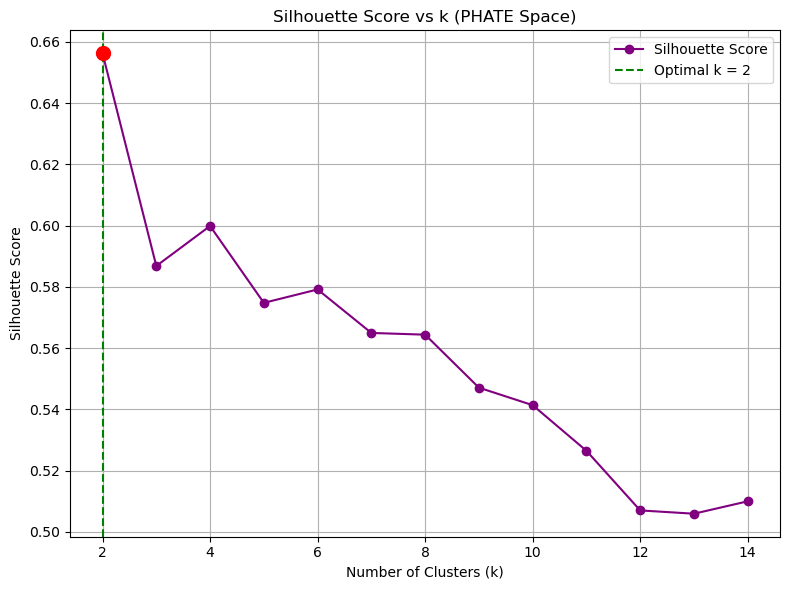

<Figure size 700x500 with 0 Axes>

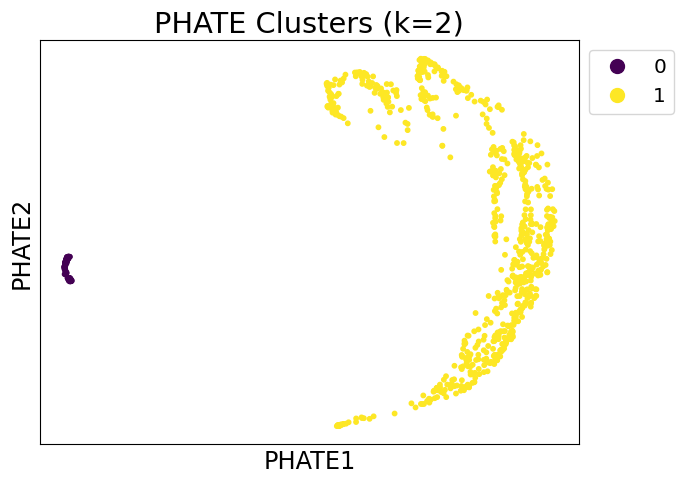

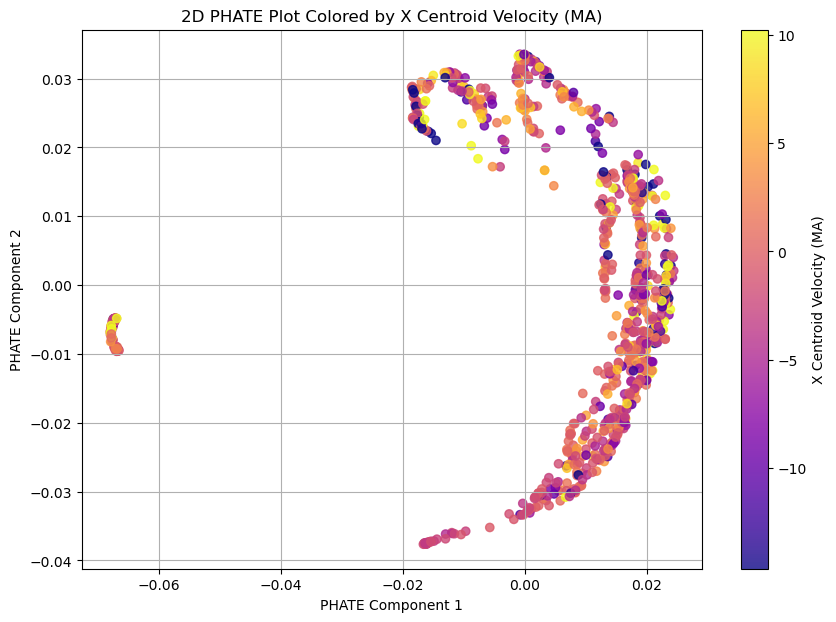

/tmp/ipykernel_1998856/1815212875.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=phate_df, x="Cluster", y="X_Centroid_Velocity_MA", palette="Set2")


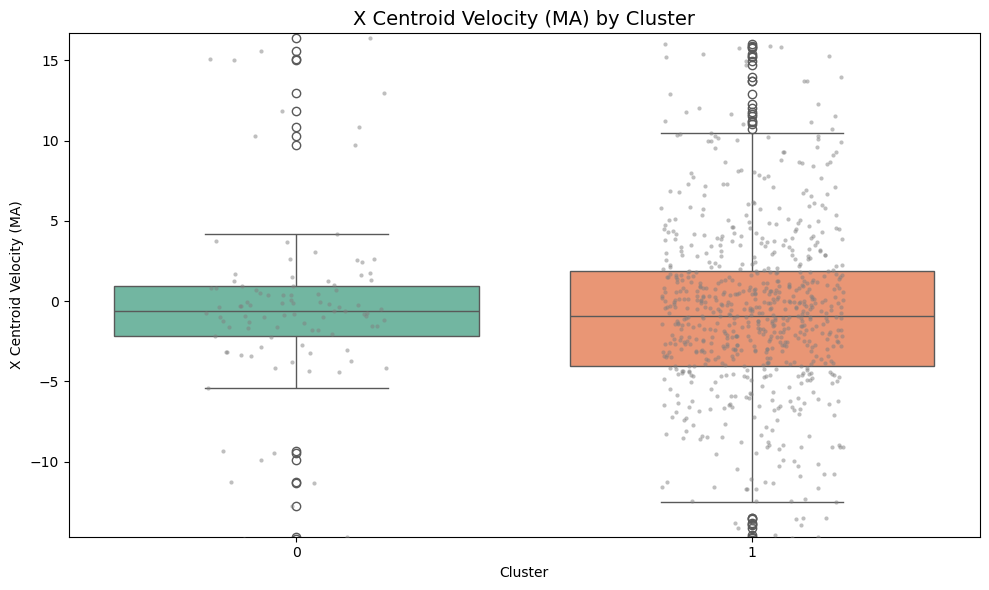

     PHATE1    PHATE2  Cell Number  X_Centroid_Velocity_MA  Cluster
0 -0.009955  0.028826            1                6.776798        1
1 -0.010590  0.029122            1                7.682738        1
2 -0.009491  0.026915            1              -11.292174        1
3 -0.006613  0.023135            1               -9.227176        1
4 -0.003262  0.019697            1               -8.791865        1
5 -0.004018  0.017187            1               -2.803225        1
6 -0.005268  0.017201            1                3.773027        1
7 -0.007648  0.018354            1               12.051972        1
8 -0.008764  0.020243            1               11.794574        1
9 -0.010261  0.023439            1                8.622794        1
Best cluster count (k): 2


In [10]:

def apply_phate(csv_path, output_directory, window_size, variance_threshold=0.95):
    """Apply PCA + PHATE + dynamic KMeans clustering with optimal k selection using silhouette scores."""

    # Load data
    df = pd.read_csv(csv_path)

    # Select relevant columns
    selected_columns = [
        "Cell Number", "Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA",
        "Compactness_MA", "Elongation_MA", "Circularity_MA", "Convexity_MA",
        "X_Centroid_Velocity_MA", "Y_Centroid_Velocity_MA"
    ]
    mini_df = df[selected_columns].copy()

    # Drop 'Cell Number' and velocities for PCA features
    feature_cols = mini_df.drop(columns=["Cell Number", "X_Centroid_Velocity_MA", "Y_Centroid_Velocity_MA"]).columns.tolist()

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(mini_df[feature_cols])

    # Apply PCA for variance explanation
    pca = PCA()
    pca.fit(X_scaled)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    optimal_components = np.argmax(cumulative_variance >= variance_threshold) + 1

    print(f"Optimal PCA components to retain {variance_threshold * 100:.0f}% variance: {optimal_components}")

    # Apply PCA with optimal components
    pca = PCA(n_components=optimal_components)
    X_pca = pca.fit_transform(X_scaled)
    print(f"PCA Variance Explained: {np.sum(pca.explained_variance_ratio_):.4f}")

    # Apply PHATE
    phate_operator = phate.PHATE(n_components=2, knn=30, random_state=42)
    X_phate = phate_operator.fit_transform(X_pca)

    # Determine optimal k using silhouette score
    silhouette_scores = []
    k_range = range(2, 15)
    for k in k_range:
        kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(X_phate)
        score = silhouette_score(X_phate, kmeans_temp.labels_)
        silhouette_scores.append(score)

    optimal_k = k_range[np.argmax(silhouette_scores)]
    optimal_score = max(silhouette_scores)
    print(f"Optimal number of clusters based on silhouette score: k={optimal_k}, score={optimal_score:.4f}")

    # Plot silhouette scores
    plt.figure(figsize=(8, 6))
    plt.plot(k_range, silhouette_scores, marker='o', linestyle='-', color='purple', label="Silhouette Score")
    plt.axvline(x=optimal_k, color='green', linestyle='--', label=f"Optimal k = {optimal_k}")
    plt.scatter(optimal_k, optimal_score, color='red', s=100, zorder=5)
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Score vs k (PHATE Space)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig(os.path.join(output_directory, f"PHATE_Silhouette_Scores_{window_size}.png"))
    plt.show()

    # Apply k-means with optimal k
    kmeans = KMeans(n_clusters=optimal_k, random_state=44, n_init='auto')
    clusters = kmeans.fit_predict(X_phate)

    # Save PHATE results
    phate_df = pd.DataFrame(X_phate, columns=["PHATE1", "PHATE2"])
    phate_df["Cell Number"] = mini_df["Cell Number"]
    phate_df["X_Centroid_Velocity_MA"] = mini_df["X_Centroid_Velocity_MA"]
    phate_df["Cluster"] = clusters

    # Save to CSV
    phate_df.to_csv(os.path.join(output_directory, f"PHATE_Embedding_Clustered_{window_size}.csv"), index=False)

    # Plot PHATE Clusters
    plt.figure(figsize=(7, 5))
    scprep.plot.scatter2d(
        X_phate, c=clusters, cmap="viridis", s=10,
        figsize=(7, 5), ticks=None, label_prefix='PHATE',
        legend_anchor=(1, 1), fontsize=12, title=f'PHATE Clusters (k={optimal_k})'
    )

    plt.savefig(os.path.join(output_directory, f"PHATE_Clusters_X_Centroid_Velocity_MA_{window_size}.png"))
    plt.show()

    # Plot cluster centroids
    # centroids = kmeans.cluster_centers_
    # plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=60, alpha=0.6, marker='o', label='Centroids')
    # plt.legend()
    # plt.savefig(os.path.join(output_directory, f"PHATE_Clusters_MA_{window_size}.png"))
    # plt.show()

    # Plot PHATE colored by Y Centroid Velocity (with clipping)
    vmin = np.percentile(phate_df["X_Centroid_Velocity_MA"], 5)
    vmax = np.percentile(phate_df["X_Centroid_Velocity_MA"], 95)

    plt.figure(figsize=(10, 7))
    sc_vel = plt.scatter(phate_df["PHATE1"], phate_df["PHATE2"],
                         c=phate_df["X_Centroid_Velocity_MA"], cmap='plasma', alpha=0.8, vmin=vmin, vmax=vmax)
    plt.colorbar(sc_vel, label="X Centroid Velocity (MA)")
    plt.title("2D PHATE Plot Colored by X Centroid Velocity (MA)")
    plt.xlabel("PHATE Component 1")
    plt.ylabel("PHATE Component 2")
    plt.grid(True)
    plt.savefig(os.path.join(output_directory, f"PHATE_Centroid_Velocity_MA_{window_size}.png"))
    plt.show()



        

    # --- Seaborn Boxplot: X Centroid Velocity by Cluster ---
    vmin = phate_df["X_Centroid_Velocity_MA"].quantile(0.05)
    vmax = phate_df["X_Centroid_Velocity_MA"].quantile(0.99)
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=phate_df, x="Cluster", y="X_Centroid_Velocity_MA", palette="Set2")
    sns.stripplot(data=phate_df, x="Cluster", y="X_Centroid_Velocity_MA", color='gray', alpha=0.5, jitter=0.2, size=3)
    plt.title("X Centroid Velocity (MA) by Cluster", fontsize=14)
    plt.xlabel("Cluster")
    plt.ylabel("X Centroid Velocity (MA)")
    plt.tight_layout()
    plt.ylim(vmin, vmax)
    plt.savefig(os.path.join(output_directory, f"Phate_Boxplot_X_Velocity_By_Cluster_{window_size}.png"))
    plt.show()

    return phate_df, optimal_k

# # Optional: plot colored by feature
# def color_by_feature(phate_df, feature, output_directory, window_size):
#     vmin = np.percentile(phate_df[feature], 5)
#     vmax = np.percentile(phate_df[feature], 95)
#     plt.figure(figsize=(10, 7))
#     sc = plt.scatter(phate_df["PHATE1"], phate_df["PHATE2"], c=phate_df[feature],
#                      cmap='plasma', alpha=0.8, vmin=vmin, vmax=vmax)
#     plt.colorbar(sc, label=feature)
#     plt.title(f"2D PHATE Plot Colored by {feature}")
#     plt.xlabel("PHATE Component 1")
#     plt.ylabel("PHATE Component 2")
#     plt.grid(True)
#     # plt.savefig(os.path.join(output_directory, f"PHATE_Colored_by_{feature}_{window_size}.png"))
#     plt.show()




window_size = 5
output_directory = "/home/MinaHossain/EmbedTrack/Track_New_Result_Shape/Mean"
input_directory = "/home/MinaHossain/EmbedTrack/Track_New_Result_Shape/Mean"
csv_path = os.path.join(input_directory, f"Cells_Centroid_Velocity_TrueLabel_MA_Mean_{window_size}.csv")

phate_results, best_k = apply_phate(csv_path, output_directory, window_size)
print(phate_results.head(10))
print(f"Best cluster count (k): {best_k}")

# mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/Track_New"
# output_directory = "/home/MinaHossain/EmbedTrack/Cell_Frame-Video/Track_New_Output"

# # Optionally, color by another feature
# color_by_feature(phate_results, "X_Centroid_Velocity_MA", output_directory, window_size)


Optimal PCA components to retain 95% variance: 3
PCA Variance Explained: 0.9526
Calculating PHATE...
  Running PHATE on 860 observations and 3 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.03 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.04 seconds.
  Calculating optimal t...


    Automatically selected t = 12
  Calculated optimal t in 0.19 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.06 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.38 seconds.
Calculated PHATE in 0.68 seconds.
Optimal number of clusters based on silhouette score: k=2, score=0.6564


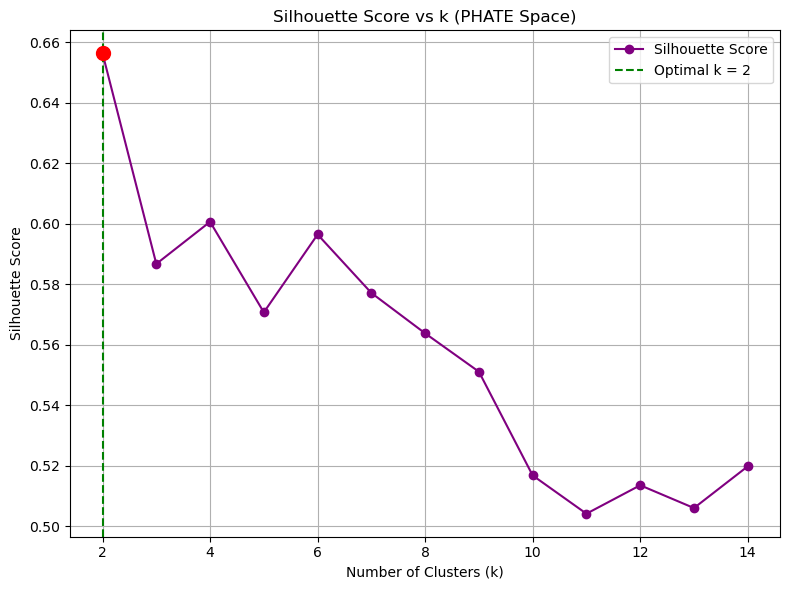

<Figure size 700x500 with 0 Axes>

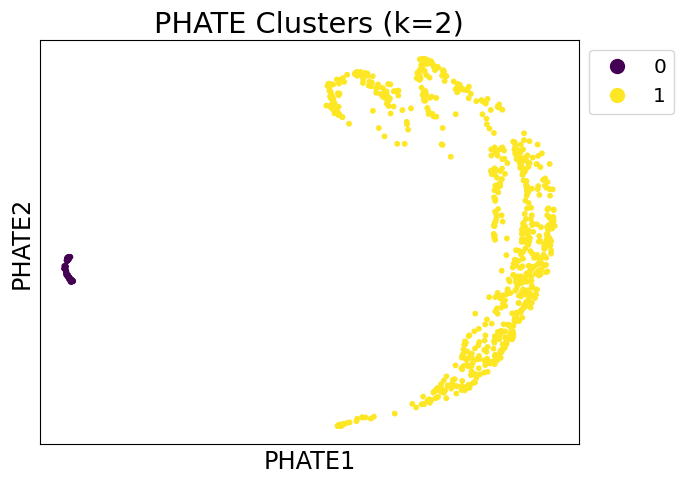

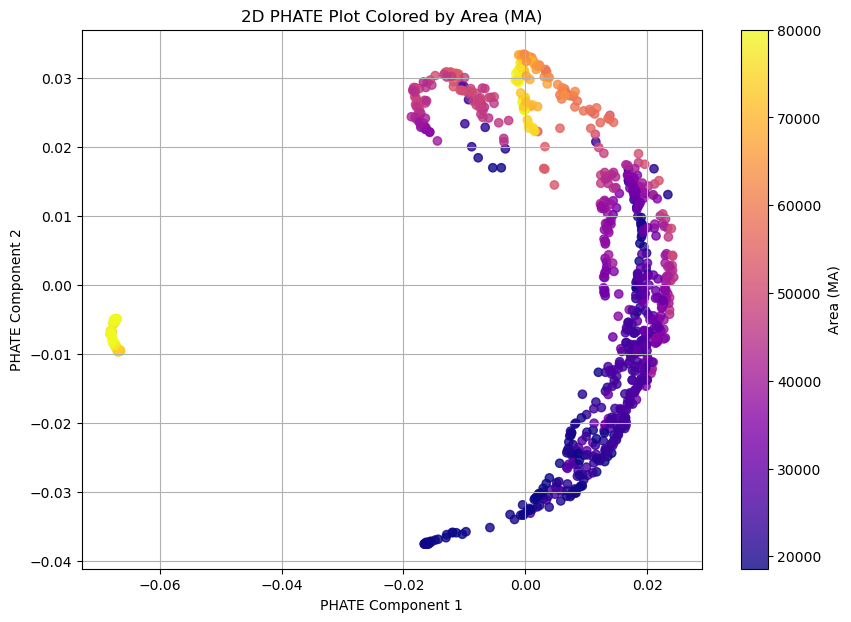

/tmp/ipykernel_1998856/2495029953.py:142: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=phate_df, x="Cluster", y="Area_MA", palette="Set2")


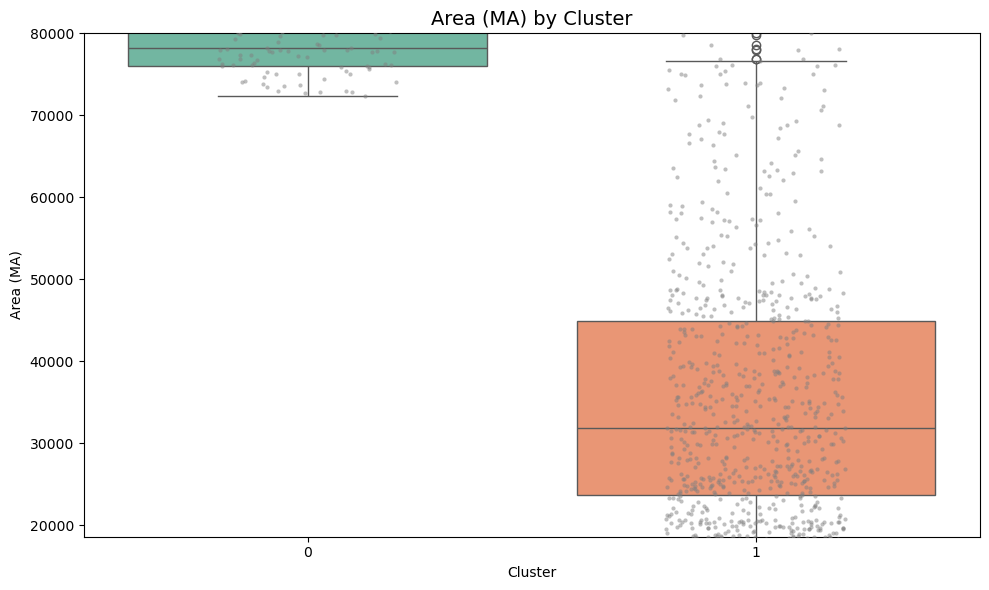

     PHATE1    PHATE2  Cell Number       Area_MA  Cluster
0 -0.010106  0.028849            1  26265.000000        1
1 -0.010581  0.029073            1  27551.500000        1
2 -0.009308  0.026871            1  23668.333333        1
3 -0.006575  0.022859            1  21889.750000        1
4 -0.003271  0.019735            1  20706.400000        1
5 -0.003934  0.016993            1  18648.000000        1
6 -0.005331  0.016994            1  17878.400000        1
7 -0.007731  0.018441            1  19636.600000        1
8 -0.008795  0.020042            1  21484.400000        1
9 -0.009917  0.023375            1  23242.600000        1
Best cluster count (k): 2


In [11]:

def apply_phate(csv_path, output_directory, window_size, variance_threshold=0.95):
    """Apply PCA + PHATE + dynamic KMeans clustering with optimal k selection using silhouette scores."""

    # Load data
    df = pd.read_csv(csv_path)

    # Select relevant columns
    selected_columns = [
        "Cell Number", "Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA",
        "Compactness_MA", "Elongation_MA", "Circularity_MA", "Convexity_MA",
        "X_Centroid_Velocity_MA", "Y_Centroid_Velocity_MA"
    ]
    mini_df = df[selected_columns].copy()

    # Drop 'Cell Number' and velocities for PCA features
    feature_cols = mini_df.drop(columns=["Cell Number", "X_Centroid_Velocity_MA", "Y_Centroid_Velocity_MA"]).columns.tolist()

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(mini_df[feature_cols])

    # Apply PCA for variance explanation
    pca = PCA()
    pca.fit(X_scaled)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    optimal_components = np.argmax(cumulative_variance >= variance_threshold) + 1

    print(f"Optimal PCA components to retain {variance_threshold * 100:.0f}% variance: {optimal_components}")

    # Apply PCA with optimal components
    pca = PCA(n_components=optimal_components)
    X_pca = pca.fit_transform(X_scaled)
    print(f"PCA Variance Explained: {np.sum(pca.explained_variance_ratio_):.4f}")

    # Apply PHATE
    phate_operator = phate.PHATE(n_components=2, knn=30, random_state=44)
    X_phate = phate_operator.fit_transform(X_pca)

    # Determine optimal k using silhouette score
    silhouette_scores = []
    k_range = range(2, 15)
    for k in k_range:
        kmeans_temp = KMeans(n_clusters=k, random_state=44, n_init='auto').fit(X_phate)
        score = silhouette_score(X_phate, kmeans_temp.labels_)
        silhouette_scores.append(score)

    optimal_k = k_range[np.argmax(silhouette_scores)]
    optimal_score = max(silhouette_scores)
    print(f"Optimal number of clusters based on silhouette score: k={optimal_k}, score={optimal_score:.4f}")

    # Plot silhouette scores
    plt.figure(figsize=(8, 6))
    plt.plot(k_range, silhouette_scores, marker='o', linestyle='-', color='purple', label="Silhouette Score")
    plt.axvline(x=optimal_k, color='green', linestyle='--', label=f"Optimal k = {optimal_k}")
    plt.scatter(optimal_k, optimal_score, color='red', s=100, zorder=5)
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Score vs k (PHATE Space)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig(os.path.join(output_directory, f"PHATE_Silhouette_Scores_{window_size}.png"))
    plt.show()

    # Apply k-means with optimal k
    kmeans = KMeans(n_clusters=optimal_k, random_state=44, n_init='auto')
    clusters = kmeans.fit_predict(X_phate)

    # Save PHATE results
    phate_df = pd.DataFrame(X_phate, columns=["PHATE1", "PHATE2"])
    phate_df["Cell Number"] = mini_df["Cell Number"]
    # phate_df["Y_Centroid_Velocity_MA"] = mini_df["Y_Centroid_Velocity_MA"]
    phate_df["Area_MA"] = mini_df["Area_MA"]
    phate_df["Cluster"] = clusters

    # Save to CSV
    phate_df.to_csv(os.path.join(output_directory, f"PHATE_Embedding_Clustered_{window_size}.csv"), index=False)

    # Plot PHATE Clusters
    plt.figure(figsize=(7, 5))
    scprep.plot.scatter2d(
        X_phate, c=clusters, cmap="viridis", s=10,
        figsize=(7, 5), ticks=None, label_prefix='PHATE',
        legend_anchor=(1, 1), fontsize=12, title=f'PHATE Clusters (k={optimal_k})'
    )

    plt.savefig(os.path.join(output_directory, f"PHATE_Clusters_Area_MA_{window_size}.png"))
    plt.show()

    # Plot cluster centroids
    # centroids = kmeans.cluster_centers_
    # plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=60, alpha=0.6, marker='o', label='Centroids')
    # plt.legend()
    # plt.savefig(os.path.join(output_directory, f"PHATE_Clusters_MA_{window_size}.png"))
    # plt.show()

    # Plot PHATE colored by Y Centroid Velocity (with clipping)
    # vmin = np.percentile(phate_df["Y_Centroid_Velocity_MA"], 5)
    # vmax = np.percentile(phate_df["Y_Centroid_Velocity_MA"], 95)

    vmin = np.percentile(phate_df["Area_MA"], 5)
    vmax = np.percentile(phate_df["Area_MA"], 95)

    plt.figure(figsize=(10, 7))
    # sc_vel = plt.scatter(phate_df["PHATE1"], phate_df["PHATE2"],
    #                      c=phate_df["Y_Centroid_Velocity_MA"], cmap='plasma', alpha=0.8, vmin=vmin, vmax=vmax)
    # plt.colorbar(sc_vel, label="Y Centroid Velocity (MA)")
    # plt.title("2D PHATE Plot Colored by Y Centroid Velocity (MA)")


    sc_vel = plt.scatter(phate_df["PHATE1"], phate_df["PHATE2"],
                         c=phate_df["Area_MA"], cmap='plasma', alpha=0.8, vmin=vmin, vmax=vmax)
    plt.colorbar(sc_vel, label="Area (MA)")
    plt.title("2D PHATE Plot Colored by Area (MA)")



    plt.xlabel("PHATE Component 1")
    plt.ylabel("PHATE Component 2")
    plt.grid(True)
    plt.savefig(os.path.join(output_directory, f"PHATE_Area_MA_{window_size}.png"))
    plt.show()



        

    # --- Seaborn Boxplot: X Centroid Velocity by Cluster ---
    # vmin = phate_df["Y_Centroid_Velocity_MA"].quantile(0.05)
    # vmax = phate_df["Y_Centroid_Velocity_MA"].quantile(0.95)

    vmin = phate_df["Area_MA"].quantile(0.05)
    vmax = phate_df["Area_MA"].quantile(0.95)


    plt.figure(figsize=(10, 6))
    # sns.boxplot(data=phate_df, x="Cluster", y="Y_Centroid_Velocity_MA", palette="Set2")
    # sns.stripplot(data=phate_df, x="Cluster", y="Y_Centroid_Velocity_MA", color='gray', alpha=0.5, jitter=0.2, size=3)
    # plt.title("Y Centroid Velocity (MA) by Cluster", fontsize=14)
    # plt.ylabel("Y Centroid Velocity (MA)")

    sns.boxplot(data=phate_df, x="Cluster", y="Area_MA", palette="Set2")
    sns.stripplot(data=phate_df, x="Cluster", y="Area_MA", color='gray', alpha=0.5, jitter=0.2, size=3)
    plt.title("Area (MA) by Cluster", fontsize=14)
    plt.ylabel("Area (MA)")



    plt.xlabel("Cluster")
    plt.tight_layout()
    plt.ylim(vmin, vmax)
    plt.savefig(os.path.join(output_directory, f"Phate_Boxplot_Area_By_Cluster_{window_size}.png"))
    plt.show()

    return phate_df, optimal_k

# # Optional: plot colored by feature
# def color_by_feature(phate_df, feature, output_directory, window_size):
#     vmin = np.percentile(phate_df[feature], 5)
#     vmax = np.percentile(phate_df[feature], 95)
#     plt.figure(figsize=(10, 7))
#     sc = plt.scatter(phate_df["PHATE1"], phate_df["PHATE2"], c=phate_df[feature],
#                      cmap='plasma', alpha=0.8, vmin=vmin, vmax=vmax)
#     plt.colorbar(sc, label=feature)
#     plt.title(f"2D PHATE Plot Colored by {feature}")
#     plt.xlabel("PHATE Component 1")
#     plt.ylabel("PHATE Component 2")
#     plt.grid(True)
#     # plt.savefig(os.path.join(output_directory, f"PHATE_Colored_by_{feature}_{window_size}.png"))
#     plt.show()




window_size = 5
output_directory = "/home/MinaHossain/EmbedTrack/Track_New_Result_Shape/Mean"
input_directory = "/home/MinaHossain/EmbedTrack/Track_New_Result_Shape/Mean"
csv_path = os.path.join(input_directory, f"Cells_Centroid_Velocity_TrueLabel_MA_Mean_{window_size}.csv")

phate_results, best_k = apply_phate(csv_path, output_directory, window_size)
print(phate_results.head(10))
print(f"Best cluster count (k): {best_k}")


# mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/Track_New"
# output_directory = "/home/MinaHossain/EmbedTrack/Cell_Frame-Video/Track_New_Output"

# # Optionally, color by another feature
# color_by_feature(phate_results, "X_Centroid_Velocity_MA", output_directory, window_size)


# Fixed Number of Clusters (Not Required)

In [26]:

# def apply_phate(csv_path, output_directory, window_size, variance_threshold=0.95, fixed_k=4):
#     """Apply PCA + PHATE + KMeans clustering with a fixed number of clusters (k=5)."""

#     # Load data
#     df = pd.read_csv(csv_path)

#     # Select relevant columns
#     selected_columns = [
#         "Cell Number", "Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA",
#         "Compactness_MA", "Elongation_MA", "Circularity_MA", "Convexity_MA",
#         "X_Centroid_Velocity_MA", "Y_Centroid_Velocity_MA"
#     ]
#     mini_df = df[selected_columns].copy()

#     # Drop 'Cell Number' and velocities for PCA features
#     feature_cols = mini_df.drop(columns=["Cell Number", "X_Centroid_Velocity_MA", "Y_Centroid_Velocity_MA"]).columns.tolist()

#     # Standardize features
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(mini_df[feature_cols])

#     # Apply PCA for variance explanation
#     pca = PCA()
#     pca.fit(X_scaled)
#     cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
#     optimal_components = np.argmax(cumulative_variance >= variance_threshold) + 1

#     print(f"Optimal PCA components to retain {variance_threshold * 100:.0f}% variance: {optimal_components}")

#     # Apply PCA with optimal components
#     pca = PCA(n_components=optimal_components)
#     X_pca = pca.fit_transform(X_scaled)
#     print(f"PCA Variance Explained: {np.sum(pca.explained_variance_ratio_):.4f}")

#     # Apply PHATE
#     phate_operator = phate.PHATE(n_components=2, knn=30, random_state=44)
#     X_phate = phate_operator.fit_transform(X_pca)

#     # Apply k-means with fixed k
#     kmeans = KMeans(n_clusters=fixed_k, random_state=44, n_init='auto')
#     clusters = kmeans.fit_predict(X_phate)

#     # Save PHATE results
#     phate_df = pd.DataFrame(X_phate, columns=["PHATE1", "PHATE2"])
#     phate_df["Cell Number"] = mini_df["Cell Number"]
#     phate_df["X_Centroid_Velocity_MA"] = mini_df["X_Centroid_Velocity_MA"]
#     phate_df["Cluster"] = clusters

#     # Save to CSV
#     phate_df.to_csv(os.path.join(output_directory, f"PHATE_Embedding_Clustered_k{fixed_k}_MA_{window_size}.csv"), index=False)

#     # Plot PHATE Clusters
#     plt.figure(figsize=(7, 5))
#     scprep.plot.scatter2d(
#         X_phate, c=clusters, cmap="viridis", s=10,
#         figsize=(7, 5), ticks=None, label_prefix='PHATE',
#         legend_anchor=(1, 1), fontsize=12, title=f'PHATE Clusters (k={fixed_k})'
#     )
    
#     plt.savefig(os.path.join(output_directory, f"PHATE_Clusters_MA_{window_size}.png"))
#     plt.show()

#     # Plot cluster centroids
#     # centroids = kmeans.cluster_centers_
#     # plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=60, alpha=0.6, marker='o', label='Centroids')
#     # plt.legend()
#     # plt.show()

#     # Plot PHATE colored by X Centroid Velocity (with clipping)
#     vmin = np.percentile(phate_df["X_Centroid_Velocity_MA"], 5)
#     vmax = np.percentile(phate_df["X_Centroid_Velocity_MA"], 95)

#     plt.figure(figsize=(10, 7))
#     sc_vel = plt.scatter(phate_df["PHATE1"], phate_df["PHATE2"],
#                          c=phate_df["X_Centroid_Velocity_MA"], cmap='plasma', alpha=0.8, vmin=vmin, vmax=vmax)
#     plt.colorbar(sc_vel, label="X Centroid Velocity (MA)")
#     plt.title("2D PHATE Plot Colored by X Centroid Velocity (MA)")
#     plt.xlabel("PHATE Component 1")
#     plt.ylabel("PHATE Component 2")
#     plt.grid(True)
#     plt.show()

#     # Seaborn Boxplot: X Centroid Velocity by Cluster
    
#     vmin = phate_df["X_Centroid_Velocity_MA"].quantile(0.05)
#     vmax = phate_df["X_Centroid_Velocity_MA"].quantile(0.95)
#     plt.figure(figsize=(10, 6))
#     sns.boxplot(data=phate_df, x="Cluster", y="X_Centroid_Velocity_MA", palette="Set2")
#     sns.stripplot(data=phate_df, x="Cluster", y="X_Centroid_Velocity_MA", color='gray', alpha=0.5, jitter=0.2, size=3)
#     plt.title("X Centroid Velocity (MA) by Cluster", fontsize=14)
#     plt.xlabel("Cluster")
#     plt.ylabel("X Centroid Velocity (MA)")
#     plt.tight_layout()
#     plt.ylim(vmin, vmax)
#     # plt.savefig(os.path.join(output_directory, f"Seaborn_Boxplot_XVelocity_By_Cluster_{window_size}.png"))
#     plt.show()

#     return phate_df, fixed_k


# window_size = 5
# output_directory = "/home/MinaHossain/EmbedTrack/Cell_Frame-Video/Track_New_Output"

# input_directory = "/home/MinaHossain/EmbedTrack/Cell_Frame-Video/Track_New_Output"


# csv_path = os.path.join(input_directory, f"Cells_Centroid_Velocity_TrueLabel_MA_Median_{window_size}.csv")

# phate_results, used_k = apply_phate(csv_path, output_directory, window_size, fixed_k=4)
# print(phate_results.head(10))
# print(f"Fixed cluster count (k): {used_k}")


In [27]:

# def apply_phate(csv_path, output_directory, window_size, variance_threshold=0.95, fixed_k=5):
#     """Apply PCA + PHATE + KMeans clustering with a fixed number of clusters (k=5)."""

#     # Load data
#     df = pd.read_csv(csv_path)

#     # Select relevant columns
#     selected_columns = [
#         "Cell Number", "Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA",
#         "Compactness_MA", "Elongation_MA", "Circularity_MA", "Convexity_MA",
#         "X_Centroid_Velocity_MA", "Y_Centroid_Velocity_MA"
#     ]
#     mini_df = df[selected_columns].copy()

#     # Drop 'Cell Number' and velocities for PCA features
#     feature_cols = mini_df.drop(columns=["Cell Number", "X_Centroid_Velocity_MA", "Y_Centroid_Velocity_MA"]).columns.tolist()

#     # Standardize features
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(mini_df[feature_cols])

#     # Apply PCA for variance explanation
#     pca = PCA()
#     pca.fit(X_scaled)
#     cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
#     optimal_components = np.argmax(cumulative_variance >= variance_threshold) + 1

#     print(f"Optimal PCA components to retain {variance_threshold * 100:.0f}% variance: {optimal_components}")

#     # Apply PCA with optimal components
#     pca = PCA(n_components=optimal_components)
#     X_pca = pca.fit_transform(X_scaled)
#     print(f"PCA Variance Explained: {np.sum(pca.explained_variance_ratio_):.4f}")

#     # Apply PHATE
#     phate_operator = phate.PHATE(n_components=2, knn=30, random_state=44)
#     X_phate = phate_operator.fit_transform(X_pca)

#     # Apply k-means with fixed k
#     kmeans = KMeans(n_clusters=fixed_k, random_state=44, n_init='auto')
#     clusters = kmeans.fit_predict(X_phate)

#     # Save PHATE results
#     phate_df = pd.DataFrame(X_phate, columns=["PHATE1", "PHATE2"])
#     phate_df["Cell Number"] = mini_df["Cell Number"]
#     phate_df["Area_MA"] = mini_df["Area_MA"]
#     phate_df["Cluster"] = clusters

#     # Save to CSV
#     phate_df.to_csv(os.path.join(output_directory, f"PHATE_Embedding_Clustered_k{fixed_k}_MA_{window_size}.csv"), index=False)

#     # Plot PHATE Clusters
#     plt.figure(figsize=(7, 5))
#     scprep.plot.scatter2d(
#         X_phate, c=clusters, cmap="viridis", s=10,
#         figsize=(7, 5), ticks=None, label_prefix='PHATE',
#         legend_anchor=(1, 1), fontsize=12, title=f'PHATE Clusters (k={fixed_k})'
#     )
    
#     # plt.savefig(os.path.join(output_directory, f"PHATE_Clusters_MA_{window_size}.png"))
#     plt.show()

#     # Plot cluster centroids
#     # centroids = kmeans.cluster_centers_
#     # plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=60, alpha=0.6, marker='o', label='Centroids')
#     # plt.legend()
#     # plt.show()

#     # Plot PHATE colored by X Centroid Velocity (with clipping)
#     vmin = np.percentile(phate_df["Area_MA"], 5)
#     vmax = np.percentile(phate_df["Area_MA"], 95)

#     plt.figure(figsize=(10, 7))
#     sc_vel = plt.scatter(phate_df["PHATE1"], phate_df["PHATE2"],
#                          c=phate_df["Area_MA"], cmap='plasma', alpha=0.8, vmin=vmin, vmax=vmax)
#     plt.colorbar(sc_vel, label="Area (MA)")
#     plt.title("2D PHATE Plot Colored by Area (MA)")
#     plt.xlabel("PHATE Component 1")
#     plt.ylabel("PHATE Component 2")
#     plt.grid(True)
#     plt.show()

#     # Seaborn Boxplot: X Centroid Velocity by Cluster
    
#     vmin = phate_df["Area_MA"].quantile(0.01)
#     vmax = phate_df["Area_MA"].quantile(0.99)
#     plt.figure(figsize=(10, 6))
#     sns.boxplot(data=phate_df, x="Cluster", y="Area_MA", palette="Set2")
#     sns.stripplot(data=phate_df, x="Cluster", y="Area_MA", color='gray', alpha=0.5, jitter=0.2, size=3)
#     plt.title("Area (MA) by Cluster", fontsize=14)
#     plt.xlabel("Cluster")
#     plt.ylabel("Area (MA)")
#     plt.tight_layout()
#     plt.ylim(vmin, vmax)
#     # plt.savefig(os.path.join(output_directory, f"Seaborn_Boxplot_XVelocity_By_Cluster_{window_size}.png"))
#     plt.show()

#     return phate_df, fixed_k


# window_size = 5
# output_directory = "/home/MinaHossain/EmbedTrack/Cell_Frame-Video/Track_New_Output"

# input_directory = "/home/MinaHossain/EmbedTrack/Cell_Frame-Video/Track_New_Output"


# csv_path = os.path.join(input_directory, f"Cells_Centroid_Velocity_TrueLabel_MA_Median_{window_size}.csv")

# phate_results, used_k = apply_phate(csv_path, output_directory, window_size, fixed_k=5)
# print(phate_results.head(10))
# print(f"Fixed cluster count (k): {used_k}")
